In [1]:
library(limma)
library(survival)
library(survminer)
library(msigdbr)
library(clusterProfiler)
library(enrichplot)
library(ComplexHeatmap)
library(GSVA)
library(reshape2)
library(patchwork)

TCGA_PanCancer = readRDS("/srv/shiny-server/SNVIO_V10.1/data/TCGA/panacanlt_TCGA_log2.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

Loading required package: ggplot2

Loading required package: ggpubr



Warning message in file(con, "r"):
“URL 'https://bioconductor.org/config.yaml': status was 'Couldn't resolve host name'”
Warning message in file(con, "r"):
“URL 'http://bioconductor.org/config.yaml': status was 'Couldn't resolve host name'”
clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘enrichplot’


The following object is masked from ‘package:ggpubr’:

    color_palette


Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/Com

In [2]:
# 第一步：将所有瘤种的补体突变患者和野生型患者区分开来
TCGA_cohort_cal_pm = function(TCGA,cancer_type,gene,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

In [3]:
anno = vector()
Complement_Mut_matrix = NA
Complement_Wt_matrix = NA
for(i in setdiff(names(TCGA_PanCancer),c("DLBC","LAML"))){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION","All","Others")
    RNA_ID = colnames(TCGA_PanCancer[[i]]$rna)
    tmp_mut = intersect(tmp_cohort$mut,RNA_ID)
    tmp_wt = intersect(tmp_cohort$wt,RNA_ID)
    Complement_Mut_matrix = cbind(Complement_Mut_matrix,TCGA_PanCancer[[i]]$rna[tmp_mut])
    Complement_Wt_matrix = cbind(Complement_Wt_matrix,TCGA_PanCancer[[i]]$rna[tmp_wt])
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL

Complement_Mut_matrix$Complement_Mut_matrix = NULL
Complement_Wt_matrix$Complement_Wt_matrix = NULL

In [4]:
All_RNA = cbind(Complement_Mut_matrix,Complement_Wt_matrix)

In [5]:
ncol(All_RNA)

[1] 9410

In [6]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]

group = factor(c(rep("Mutation",ncol(Complement_Mut_matrix)),rep("Wildtype",ncol(Complement_Wt_matrix))),levels = c("Mutation","Wildtype"))
design = model.matrix(~0+group)
rownames(design) = colnames(tmp_data)
colnames(design) = c("Mutation","Wildtype")
  
fit = lmFit(tmp_data,design)
contr = makeContrasts(Mutation-Wildtype,levels = design)
diff = contrasts.fit(fit,contr)
diff = eBayes(diff)
tab = topTable(diff, sort.by = "P", n = Inf)

In [7]:
FC = tab$logFC
names(FC) = rownames(tab)
FC = sort(FC,decreasing = T)

KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [8]:
res_KEGG = GSEA(geneList = FC,TERM2GENE = KEGG[,c(1,3)],pvalueCutoff = 0.05,)
res_HALLMARK = GSEA(geneList = FC,TERM2GENE = HALLMARK[,c(1,3)],pvalueCutoff = 0.05,)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [12]:
res = GSEA(geneList = FC,TERM2GENE = rbind(KEGG[,c(1,3)],HALLMARK[,c(1,3)]),pvalueCutoff = 0.05,)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [15]:
p = c("KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY",
      "KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION",
      "KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY",
      "KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY",
      "KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY",
      "HALLMARK_INTERFERON_GAMMA_RESPONSE",
      "HALLMARK_INFLAMMATORY_RESPONSE",
      "HALLMARK_INTERFERON_ALPHA_RESPONSE",
      "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
      "HALLMARK_IL2_STAT5_SIGNALING"
     )

res@result[ res@result$ID %in% p,]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,196,0.5446612,2.320700,1.000000e-10,2.109091e-09,1.291866e-09,3670,"tags=53%, list=20%, signal=43%",CCL20/ROS1/CXCL9/IL1A/EREG/MARCO/CXCL10/TNFSF9/ADORA2B/LAMP3/PLAUR/TNFRSF9/AQP9/CSF3/HAS2/CXCL11/LIF/ICAM1/CCL5/CXCR6/IL6/IL2RB/CCL7/CD55/MET/AHR/INHBA/MMP14/IL1B/LDLR/GNA15/CXCL6/LCK/SLAMF1/CCL22/CCL24/NOD2/IL7R/ICAM4/IL15RA/NAMPT/MYC/IRF1/CD70/SPHK1/BDKRB1/MEP1A/SLC28A2/IL18RAP/IFITM1/PDPN/CCR7/SLC7A1/SERPINE1/OSM/P2RY2/LTA/TNFAIP6/LY6E/MEFV/ADM/CLEC5A/BST2/PTAFR/PCDH7/GCH1/EIF2AK2/NMI/MXD1/TNFSF15/CD48/EMP3/TIMP1/CCL17/OSMR/LYN/IL18/RGS1/IL10/RIPK2/ADRM1/LCP2/TLR2/TPBG/PVR/GPC3/RTP4/TAPBP/ATP2A2/SLC31A1/TNFSF10/IRAK2/CCRL2/FFAR2/GPR132/IRF7/IL4R/MSR1/TLR1/PROK2/CD82/C5AR1/ITGA5/FZD5
HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,196,0.6177111,2.631952,1.000000e-10,2.109091e-09,1.291866e-09,3808,"tags=56%, list=21%, signal=45%",CXCL9/IDO1/GBP6/IRF4/SLAMF7/CXCL10/PLA2G4A/CXCL11/PTGS2/GZMA/ICAM1/CCL5/IL6/IL2RB/ZBP1/BATF2/CCL7/UPP1/XCL1/SECTM1/OASL/CASP4/IFI30/MX2/CASP1/IFI27/ISG20/TAP1/MTHFD2/IL15RA/NAMPT/TNFAIP3/EPSTI1/OAS3/IRF1/CD274/TNFAIP2/ITGB7/NLRC5/SOCS3/CASP8/PSMB9/OAS2/PLSCR1/CD38/CIITA/GBP4/STAT1/C1S/IL7/TNFAIP6/LY6E/CSF2RB/LGALS3BP/BST2/GPR18/GCH1/MYD88/EIF2AK2/NMI/C1R/HLA-DQA1/ISG15/PSME2/CASP7/ARL4A/SOCS1/RIPK2/APOL6/PSMB8/KLRK1/CASP3/IFITM3/PNPT1/PELI1/HLA-DRB1/PIM1/HLA-DMA/PSMB2/LCP2/RTP4/TAPBP/HLA-A/USP18/NUP93/PSMB10/PNP/TNFSF10/XAF1/PARP12/PARP14/CD86/SPPL2A/HLA-B/IRF7/STAT2/IRF8/PSMA3/FCGR1A/IL4R/PTPN2/TRIM25/VAMP8/MVP/PTPN1/PFKP/SOD2/RNF213/LAP3
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,197,0.5853057,2.492858,1.000000e-10,2.109091e-09,1.291866e-09,3338,"tags=47%, list=18%, signal=39%",CXCL1/CCL20/SERPINB2/FOSL1/LAMB3/BCL2A1/PHLDA2/CXCL3/IL1A/CXCL10/TNFSF9/PLAUR/AREG/TNFRSF9/KYNU/CXCL11/LIF/PTGS2/ICAM1/CCL5/DUSP4/IL6/IER3/INHBA/IL1B/LDLR/CXCL6/CD80/PLAU/TNC/ZC3H12A/TAP1/IL7R/IL15RA/NAMPT/TNFAIP3/CSF2/BIRC3/MYC/IRF1/SPHK1/BCL3/TNFAIP2/SOCS3/MSC/CXCL2/CD44/IL23A/SPSB1/RNF19B/SERPINE1/CCL4/SERPINB8/SLC2A6/TNFAIP6/REL/TGIF1/MAFF/SGK1/GCH1/DUSP2/RELB/TNF/MXD1/NFKBIE/B4GALT5/PHLDA1/G0S2/FUT4/IER5/B4GALT1/MAP2K3/IL18/MAP3K8/DRAM1/PLEK/CEBPB/NR4A2/BTG3/RIPK2/FOSL2/PFKFB3/CLCF1/YRDC/TLR2/PPP1R15A/KLF4/NFKB2/ETS2/PANX1/CCRL2/BHLHE40
HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,92,0.5995393,2.263296,2.182862e-09,3.895569e-08,2.386124e-08,3650,"tags=50%, list=20%, signal=40%",CXCL10/LAMP3/CXCL11/BATF2/OASL/IFI30/CASP1/IFI27/ISG20/TAP1/EPSTI1/IRF1/CASP8/IFITM1/PSMB9/PLSCR1/OAS1/GBP4/GBP2/C1S/IL7/LY6E/LGALS3BP/BST2/EIF2AK2/SAMD9/NMI/NCOA7/ISG15/PSME2/RIPK2/PSMB8/IFITM3/PNPT1/RTP4/USP18/PARP12/PARP14/CCRL2/IRF7/STAT2/PSMA3/IL4R/TRIM25/PARP9/HLA-C
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY,KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY,KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY,116,0.5526605,2.180988,6.311717e-09,1.045942e-07,6.406630e-08,4353,"tags=55%, list=24%, signal=42%",GZMB/IFNG/RAET1L/KIR2DL4/ICAM1/PRF1/FASLG/KLRD1/FCGR3B/MICB/ULBP2/LCK/CHP2/RAC2/CSF2/TNFRSF10A/SH2D1A/ULBP3/ZAP70/ULBP1/CD244/CD247/KLRC1/TNF/FCGR3A/SH2D1B/CD48/TNFRSF10B/NRAS/PIK3CD/FCER1G/ITGAL/NCR1/HLA-E/KLRK1/CASP3/SHC1/LAT/RAET1G/LCP2/HLA-A/KIR3DL2/BID/NCR3/TNFSF10/KIR2DL3/NFATC2/HLA-B/SYK/RAC3/HLA-C/MICA/VAV1/HCST/IFNGR2/SHC4/KIR2DS4/KIR3DL1/IFNAR2/KRAS/HLA-G/ITGB2/KIR2DL1/PAK1
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,66,0.5905802,2.084768,5.998473e-07,6.325662e-06,3.874612e-06,4646,"tags=64%, list=25%, signal=48%",KIR2DL4/HSPA6/KLRD1/IFI30/TAP1/HLA-DOB/CD8A/TAP2/CTSS/CD8B/CIITA/LTA/KLRC1/HLA-F/HLA-DQA2/HLA-DQA1/PSME2/HLA-E/PSME3/H

In [23]:
tmp = res@result[ res@result$ID %in% p,]
tmp = tmp[ order(tmp$qvalues),]
tmp$ID = factor(tmp$ID,levels = rev(tmp$ID))

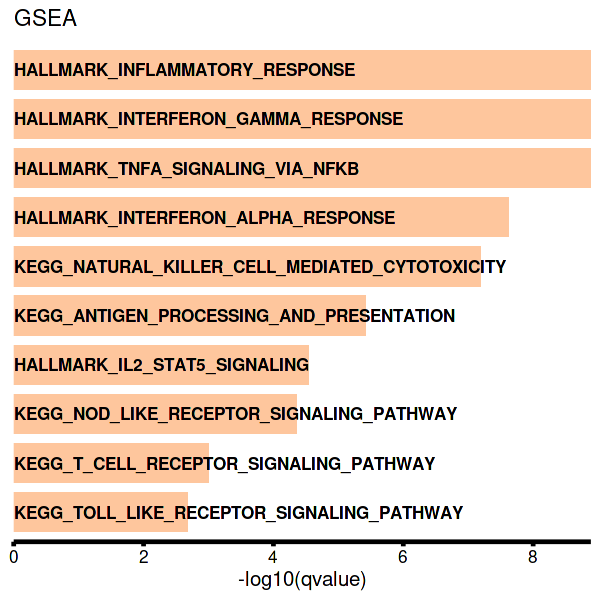

In [38]:
options(repr.plot.height = 5, repr.plot.width = 5)
ggplot(data = tmp, 
       aes(-log10(qvalues), ID)) +
  geom_bar(stat="identity",
           alpha=0.5,
           fill="#FE8D3C",
           width = 0.8) + 
  geom_text(aes(x=0,
                y=ID,
                label = ID),
            size=3.5, fontface="bold",
            hjust =0)+
  theme_classic()+
  theme(axis.text.y = element_blank(),
        axis.line.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.line.x = element_line(colour = 'black', linewidth = 1),
        axis.text.x = element_text(colour = 'black', size = 10),
        axis.ticks.x = element_line(colour = 'black', linewidth = 1),
        axis.title.x = element_text(colour = 'black', size = 12))+
  xlab("-log10(qvalue)")+
  ggtitle("GSEA")+
  scale_x_continuous(expand = c(0,0))

In [52]:
tmp = res@result[ res@result$ID %in% p,]
tmp = tmp[ order(tmp$NES,decreasing = T),]


In [53]:
tmp$ID = paste(tmp$ID,
          ifelse(tmp$qvalues < 0.001,"***",ifelse(tmp$qvalues<0.01,"**",ifelse(tmp$qvalues<0.05,"***","-"))))

tmp$ID = factor(tmp$ID,levels = rev(tmp$ID))

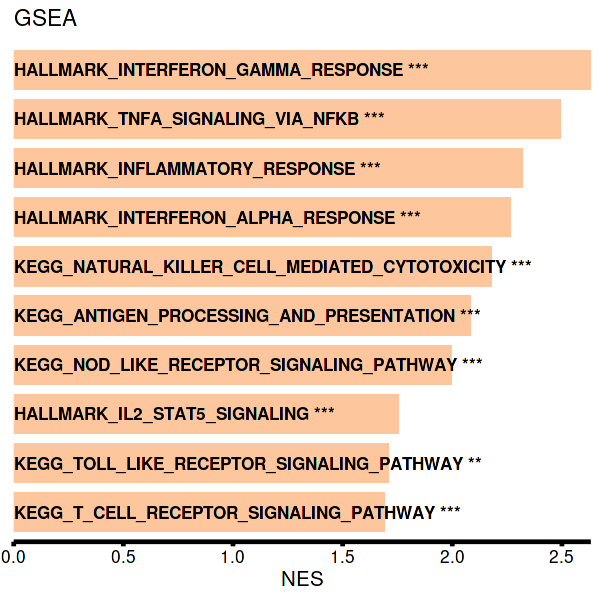

In [68]:
options(repr.plot.height = 5, repr.plot.width = 5)
ggplot(data = tmp, 
       aes(NES, ID)) +
  geom_bar(stat="identity",
           alpha=0.5,
           fill="#FE8D3C",
           width = 0.8) + 
  geom_text(aes(x=0,
                y=ID,
                label = ID),
            size=3.5, fontface="bold",
            hjust =0)+

  theme_classic()+
  theme(axis.text.y = element_blank(),
        axis.line.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.line.x = element_line(colour = 'black', linewidth = 1),
        axis.text.x = element_text(colour = 'black', size = 10),
        axis.ticks.x = element_line(colour = 'black', linewidth = 1),
        axis.title.x = element_text(colour = 'black', size = 12))+
  xlab("NES")+
  ggtitle("GSEA")+
  scale_x_continuous(expand = c(0,0))

##### the cohort of patients that have mutations in complement genes and still do not respond to ICI

In [69]:
library(ggplot2)
library(ComplexHeatmap)

In [70]:
ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

In [77]:
library(ggplot2)
library(RColorBrewer)
library(grid)
gsInfo <- function(object, geneSetID) {
    geneList <- object@geneList

    if (is.numeric(geneSetID))
        geneSetID <- object@result[geneSetID, "ID"]

    geneSet <- object@geneSets[[geneSetID]]
    exponent <- object@params[["exponent"]]
    df <- gseaScores(geneList, geneSet, exponent, fortify=TRUE)
    df$ymin <- 0
    df$ymax <- 0
    pos <- df$position == 1
    h <- diff(range(df$runningScore))/20
    df$ymin[pos] <- -h
    df$ymax[pos] <- h
    df$geneList <- geneList

    df$Description <- object@result[geneSetID, "Description"]
    return(df)
}
gseaScores <- getFromNamespace("gseaScores", "DOSE")

tableGrob2 <- function(d, p = NULL) {
    # has_package("gridExtra")
    d <- d[order(rownames(d)),]
    tp <- gridExtra::tableGrob(d,theme = gridExtra::ttheme_default(base_size = 20))
    if (is.null(p)) {
        return(tp)
    }

    # Fix bug: The 'group' order of lines and dots/path is different
    p_data <- ggplot_build(p)$data[[1]]
    # pcol <- unique(ggplot_build(p)$data[[1]][["colour"]])
    p_data <- p_data[order(p_data[["group"]]), ]
    pcol <- unique(p_data[["colour"]])
    ## This is fine too
    ## pcol <- unique(p_data[["colour"]])[unique(p_data[["group"]])]  
    j <- which(tp$layout$name == "rowhead-fg")

    for (i in seq_along(pcol)) {
        tp$grobs[j][[i+1]][["gp"]] <- gpar(col = pcol[i])
    }
    return(tp)
}

my_gseaplot2 = function (x, geneSetID, title = "",self.Description = geneSetID, color = "green", base_size = 11, 
    rel_heights = c(1.5, 0.5, 1), subplots = 1:3, pvalue_table = FALSE, title.size=28,
    ES_geom = "line") 
{
    ES_geom <- match.arg(ES_geom, c("line", "dot"))
    geneList <- position <- NULL
    if (length(geneSetID) == 1) {
        gsdata <- gsInfo(x, geneSetID)
    }
    else {
        gsdata <- do.call(rbind, lapply(geneSetID, gsInfo, object = x))
    }
    p <- ggplot(gsdata, aes_(x = ~x)) + xlab(NULL) + theme_classic(base_size) + 
        theme(panel.grid.major = element_line(colour = "grey92"), 
            panel.grid.minor = element_line(colour = "grey92"), 
            panel.grid.major.y = element_blank(), panel.grid.minor.y = element_blank()) + 
        scale_x_continuous(expand = c(0, 0))
    if (ES_geom == "line") {
        es_layer <- geom_line(aes_(y = ~runningScore, color = ~Description), 
            size = 1)
    }
    else {
        es_layer <- geom_point(aes_(y = ~runningScore, color = ~Description), 
            size = 1, data = subset(gsdata, position == 1))
    }
    p.res <- p + es_layer + theme(legend.position = c(0.8, 0.8), 
        legend.title = element_blank(), legend.background = element_rect(fill = "transparent"))
    p.res <- p.res + ylab("Running Enrichment Score") + theme(axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(), axis.line.x = element_blank(), 
        plot.margin = margin(t = 0.2, r = 0.2, b = 0, l = 0.2, 
            unit = "cm"))
    i <- 0
    for (term in unique(gsdata$Description)) {
        idx <- which(gsdata$ymin != 0 & gsdata$Description == 
            term)
        gsdata[idx, "ymin"] <- i
        gsdata[idx, "ymax"] <- i + 1
        i <- i + 1
    }
    p2 <- ggplot(gsdata, aes_(x = ~x)) + geom_linerange(aes_(ymin = ~ymin, 
        ymax = ~ymax, color = ~Description)) + xlab(NULL) + ylab(NULL) + 
        theme_classic(base_size) + theme(legend.position = "none", 
        plot.margin = margin(t = -0.1, b = 0, unit = "cm"), axis.ticks = element_blank(), 
        axis.text = element_blank(), axis.line.x = element_blank()) + 
        scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 
        0))
    if (length(geneSetID) == 1) {
        v <- seq(1, sum(gsdata$position), length.out = 9)
        inv <- findInterval(rev(cumsum(gsdata$position)), v)
        if (min(inv) == 0) 
            inv <- inv + 1
        col <- c(rev(brewer.pal(5, "Blues")), brewer.pal(5, "Reds"))
        ymin <- min(p2$data$ymin)
        yy <- max(p2$data$ymax - p2$data$ymin) * 0.3
        xmin <- which(!duplicated(inv))
        xmax <- xmin + as.numeric(table(inv)[as.character(unique(inv))])
        d <- data.frame(ymin = ymin, ymax = yy, xmin = xmin, 
            xmax = xmax, col = col[unique(inv)])
        p2 <- p2 + geom_rect(aes_(xmin = ~xmin, xmax = ~xmax, 
            ymin = ~ymin, ymax = ~ymax, fill = ~I(col)), data = d, 
            alpha = 0.9, inherit.aes = FALSE)
    }
    df2 <- p$data
    df2$y <- p$data$geneList[df2$x]
    p.pos <- p + geom_segment(data = df2, aes_(x = ~x, xend = ~x, 
        y = ~y, yend = 0), color = "grey")
    p.pos <- p.pos + ylab("Ranked List Metric") + xlab("Rank in Ordered Dataset") + 
        theme(plot.margin = margin(t = -0.1, r = 0.2, b = 0.2, l = 0.2, unit = "cm"),
              axis.title = element_text(face = "bold",size = 18),
              axis.text = element_text(size = 15))
    if (!is.null(title) && !is.na(title) && title != "") 
        p.res <- p.res + ggtitle(title)+theme(plot.title = element_text(hjust = 0.5,size = title.size,face = "bold"),
                                              axis.text.y = element_text(size = 15),
                                              axis.title.y = element_text(face = "bold",size = 18),)
    if (length(color) == length(geneSetID)) {
        p.res <- p.res + scale_color_manual(values = color)
        if (length(color) == 1) {
            p.res <- p.res + theme(legend.position = "none")
            p2 <- p2 + scale_color_manual(values = "black")
        }
        else {
            p2 <- p2 + scale_color_manual(values = color)
        }
    }
    if (pvalue_table) {
        pd <- x[geneSetID, c("Description", "pvalue", "p.adjust")]
        rownames(pd) <- self.Description
        pd <- pd[, -1]
        pd <- round(pd, 4)
        tp <- tableGrob2(pd, p.res)
        p.res <- p.res + theme(legend.position = "none") + annotation_custom(tp,
            xmin = quantile(p.res$data$x, 0.5), xmax = quantile(p.res$data$x, 
                0.95), ymin = quantile(p.res$data$runningScore, 
                0.6), ymax = quantile(p.res$data$runningScore, 
                0.8))
    }
    plotlist <- list(p.res, p2, p.pos)[subplots]
    n <- length(plotlist)
    plotlist[[n]] <- plotlist[[n]] + theme(axis.line.x = element_line(), 
        axis.ticks.x = element_line(), axis.text.x = element_text())
    if (length(subplots) == 1) 
        return(plotlist[[1]] + theme(plot.margin = margin(t = 0.2, 
            r = 0.2, b = 0.2, l = 0.2, unit = "cm")))
    if (length(rel_heights) > length(subplots)) 
        rel_heights <- rel_heights[subplots]
    plot_grid(plotlist = plotlist, ncol = 1, align = "v", rel_heights = rel_heights)
}

In [71]:
# 由于All是WES数据集的集合，是专门用于分析通路数据的，所以这里的datasets_overview也只保留跟All数据集一致的信息
# datasets = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_with_therapy.rds")
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)

All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds") # 这个RDS只有WES的数据集
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")
datasets_mu = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_mutation_with_therapy.rds")

RNA_data = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_rna_wes_with_therapy.rds")

colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)

datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = datasets_names$Cohort_name

datasets_overview = datasets_overview[names(All),]

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(All[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(All[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(All[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

datasets_overview[rownames(datasets_overview) %in% c("dataset2","dataset6","dataset8","dataset10","dataset11","dataset12","dataset13","dataset14","dataset20","dataset21"),"RNA"] = TRUE

datasets_overview$Cancer_type2 = datasets_overview$Cancer_type
datasets_overview$Cancer_type2[ datasets_overview$Cancer_type %in% 
                               c("Esophagogastric Cancer","Colorectal Cancer","Pan-GI cancer","Neuroendocrine tumours","Hepatocellular carcinoma")] = "Gastrointestinal Cancer"




In [72]:
dataset_name = datasets_overview$Cohort_name
names(dataset_name) = rownames(datasets_overview)

In [73]:
CB_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RESPONSE" %in% colnames(All[[i]]))){

    
      
    tmp_data = All[[i]][c("RESPONSE")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
    
  }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]])) &
           ! i %in% rownames(datasets_overview)[datasets_overview$RESPONSE + datasets_overview$RECIST == 2]){
      
    
      
    tmp_data = All[[i]][c("RECIST")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$CB = ifelse( tmp_data$CB %in% "PD/SD","nonresponse",ifelse( tmp_data$CB %in% "CR/PR","response",NA))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
  }
}

In [74]:
library(clusterProfiler)
library(enrichplot)
library(limma)
library(msigdbr)

KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_CC = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:CC") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_MF = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:MF") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [75]:
gl = list()
n = 1
for(i in intersect(unique(CB_total$dataset),names(RNA_data))){
    
    tmp_cm = CB_total[ CB_total$dataset == i & CB_total$groups == "Mutation", ]
    tmp_rna = RNA_data[[i]]$RNA

    share_p = intersect(rownames(tmp_cm),colnames(tmp_rna))
    message(i,":  The number of Patients:  ",length(share_p))
    tmp_cm = tmp_cm[share_p,]
    tmp_rna = tmp_rna[,share_p]

    nr_p = rownames(tmp_cm)[tmp_cm$CB %in% "nonresponse" ]
    r_p = rownames(tmp_cm)[tmp_cm$CB %in% "response" ]

    tmp_rna = tmp_rna[, c(nr_p,r_p)]
    tmp_cm = tmp_cm[c(nr_p,r_p),]

    m = apply(tmp_rna,1,function(x){sum(x>0)>round(min(length(nr_p),length(r_p))*0.8)})
    tmp_data = tmp_rna[m,]

    group = factor(tmp_cm$CB,levels = c("nonresponse","response"))
    design = model.matrix(~0+group)
    rownames(design) = colnames(tmp_data)
    colnames(design) = c("nonresponse","response")

    fit = lmFit(tmp_data,design)
    contr = makeContrasts(nonresponse-response,levels = design)
    diff = contrasts.fit(fit,contr)
    diff = eBayes(diff)
    tab = topTable(diff, sort.by = "P", n = Inf)
    
    FC = tab$logFC
    names(FC) = rownames(tab)
    FC = sort(FC,decreasing = T)
    
    res = GSEA(geneList = FC,TERM2GENE = rbind(KEGG[,c(1,3)],HALLMARK[,c(1,3)]),pvalueCutoff = 0.05)
    gl[[i]] = res
    options(repr.plot.height = 15, repr.plot.width = 10)
    if(n == 1){
        p = dotplot(res,showCategory=50,split=".sign")+facet_grid(~.sign)
    }else{
        p = p + dotplot(res,showCategory=50,split=".sign")+facet_grid(~.sign)
    }
    n = n + 1

 options(repr.plot.height = 15, repr.plot.width = 10)}

dataset2:  The number of Patients:  25

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

wrong orderBy parameter; set to default `orderBy = "x"`

dataset8:  The number of Patients:  23

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

wrong orderBy parameter; set to default `orderBy = "x"`

dataset10:  The number of Patients:  16

preparing geneSet coll

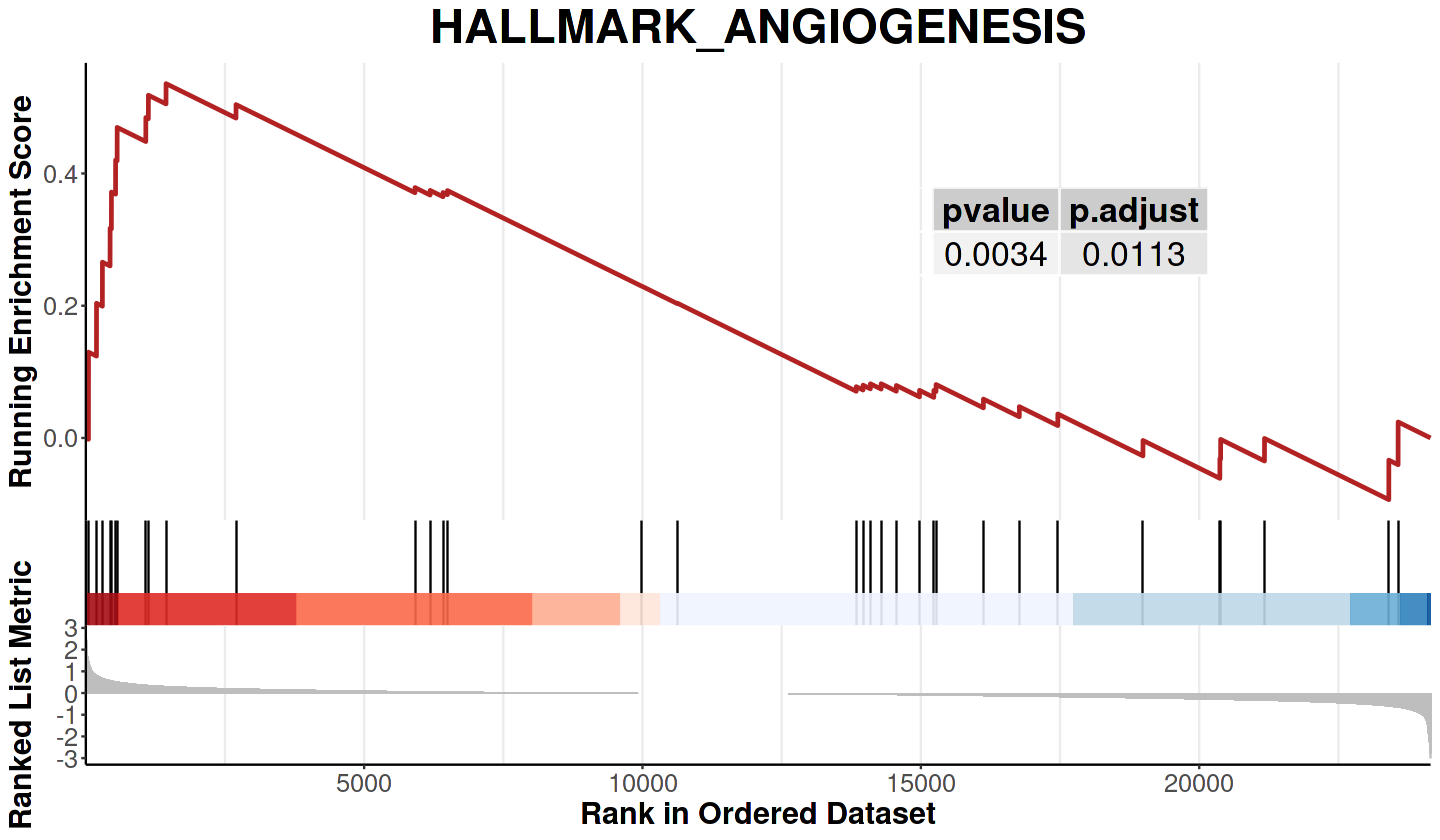

In [94]:
options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset2,"HALLMARK_ANGIOGENESIS",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_ANGIOGENESIS")

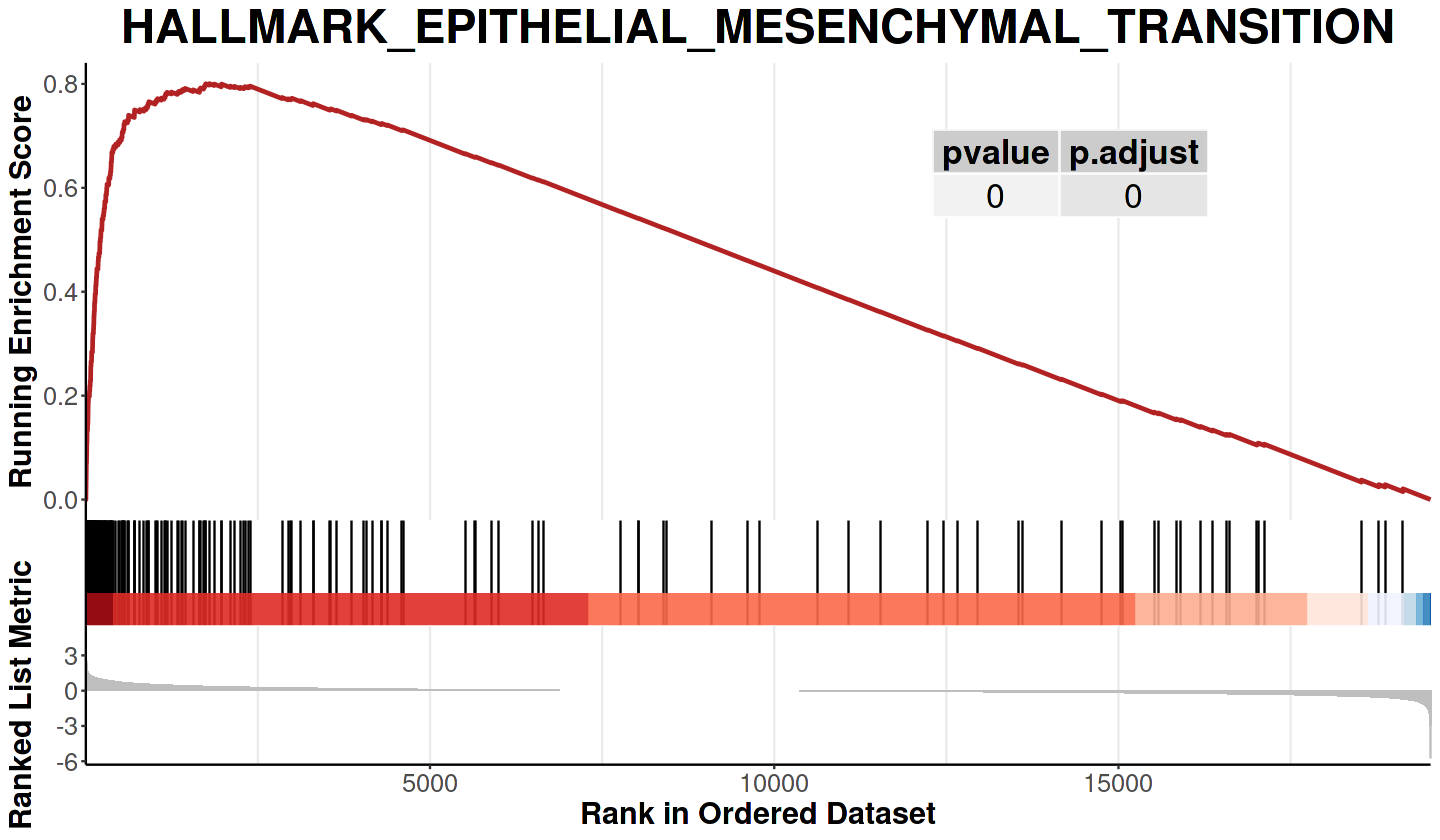

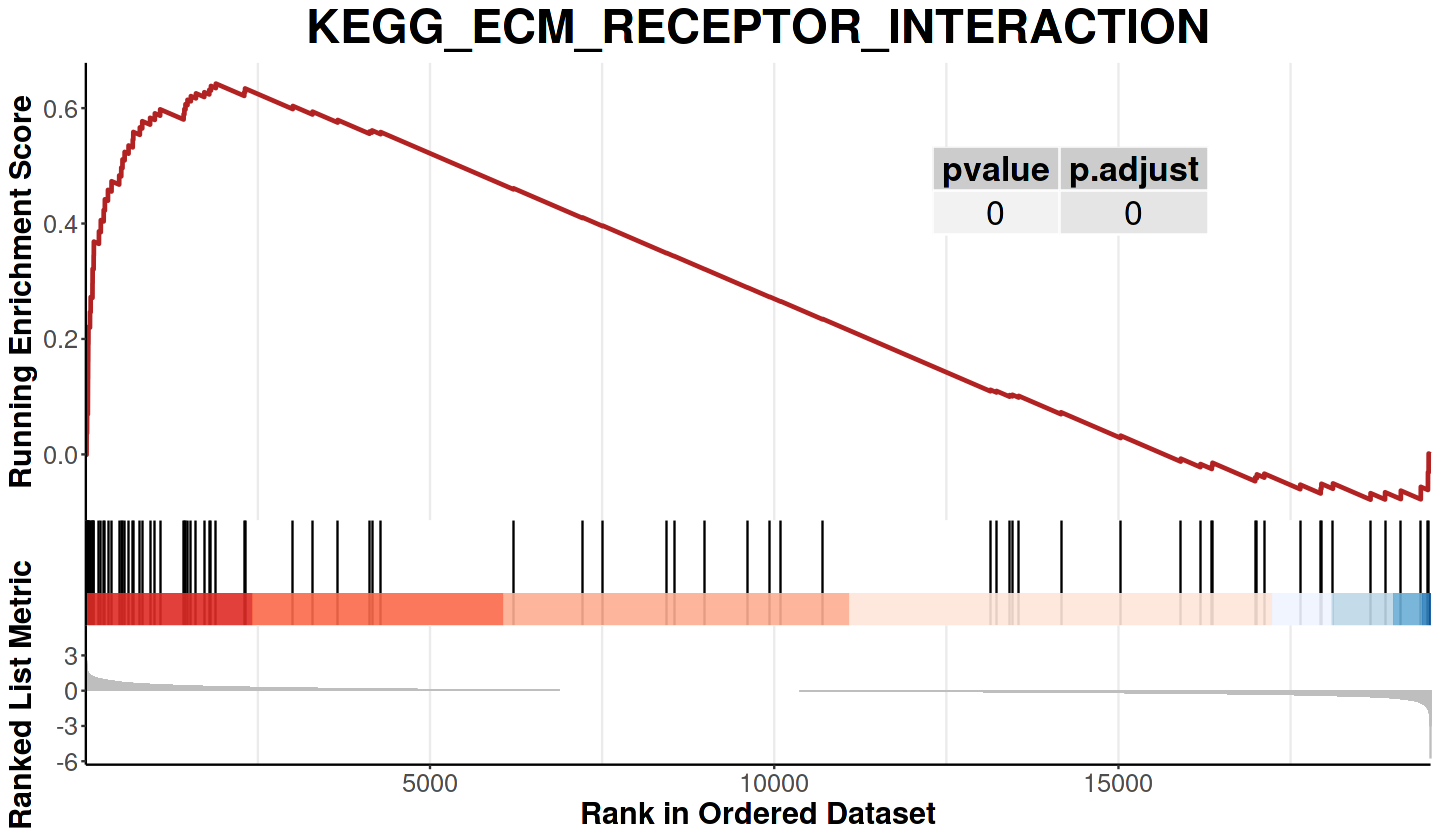

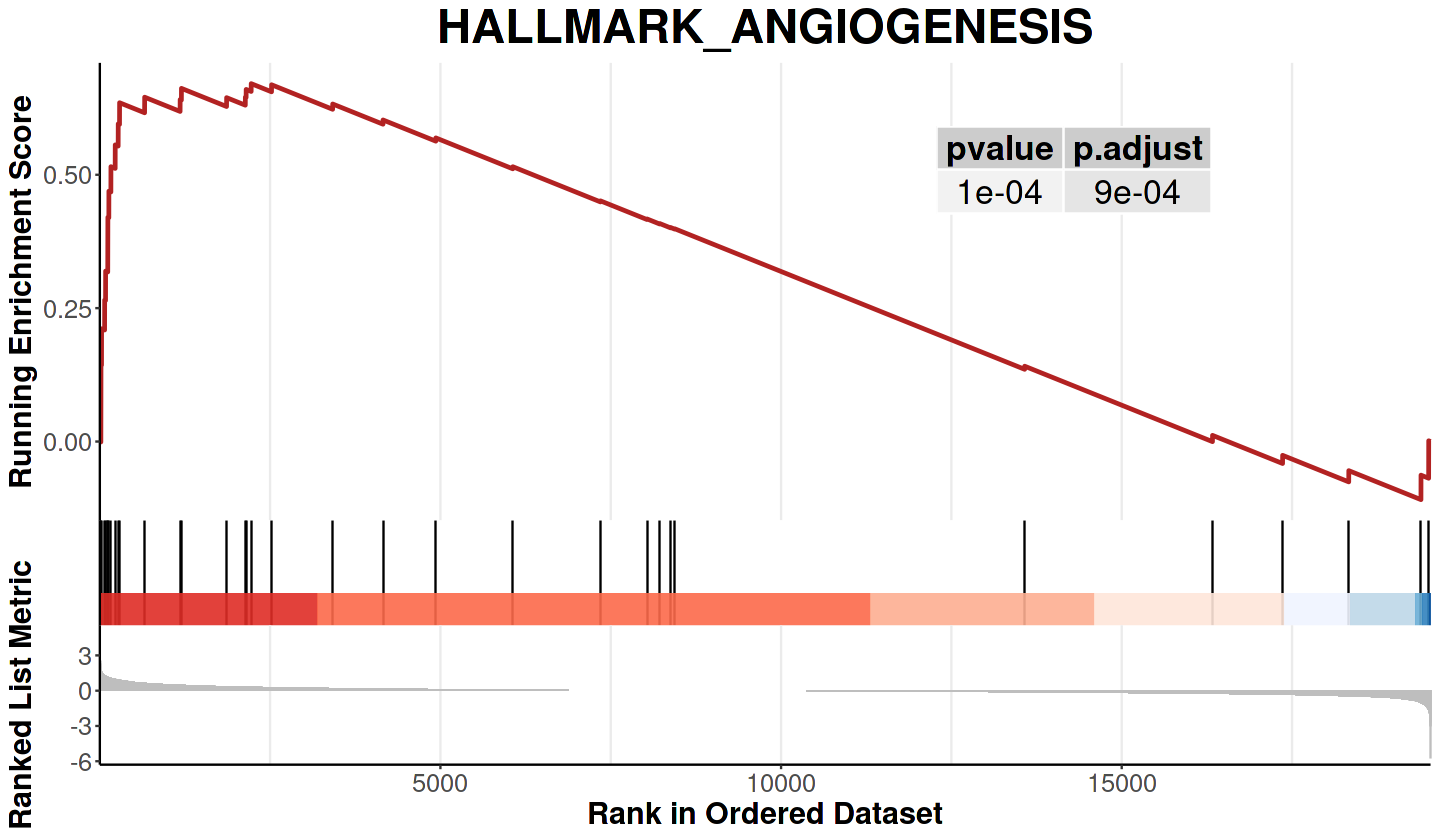

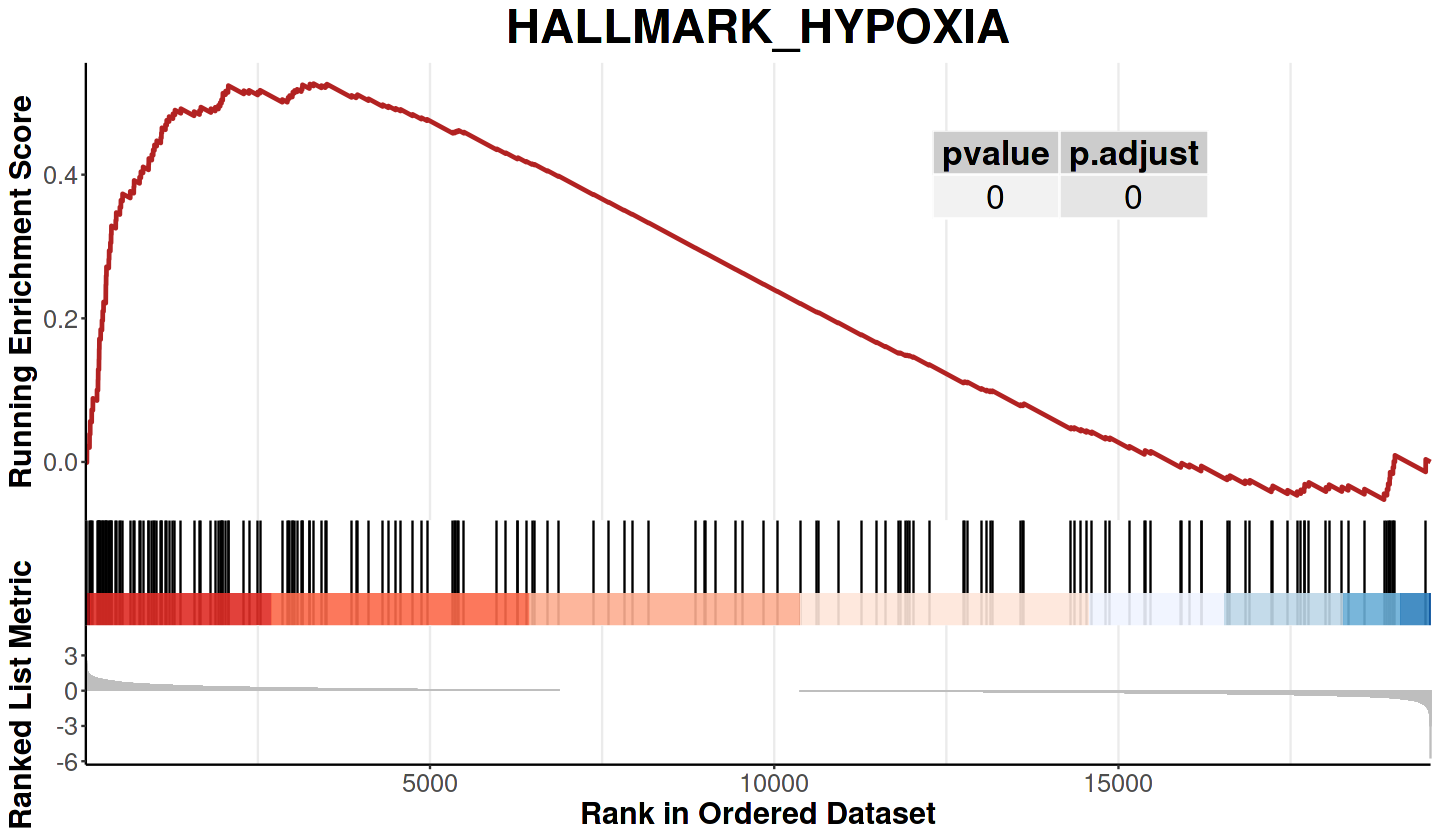

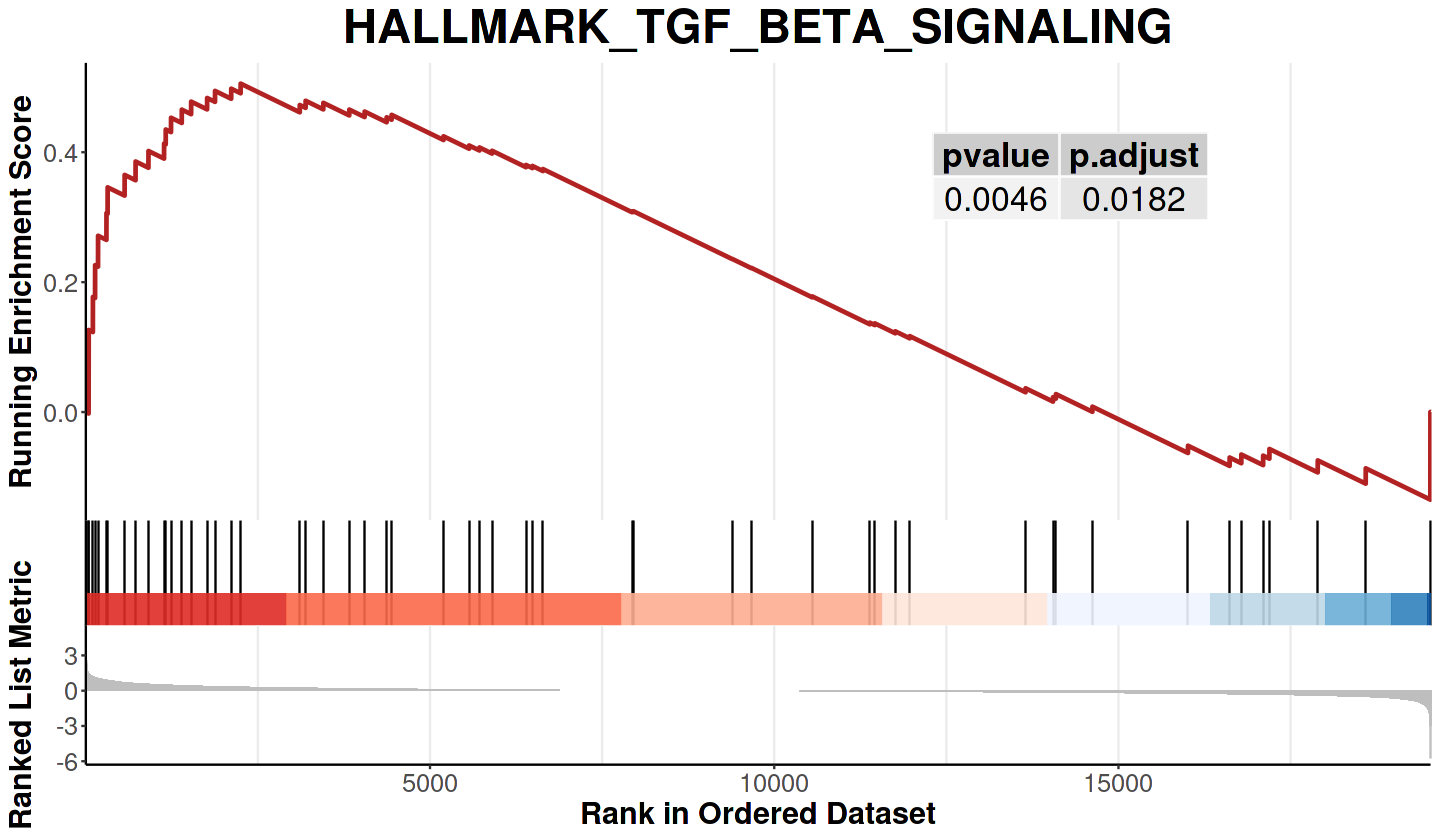

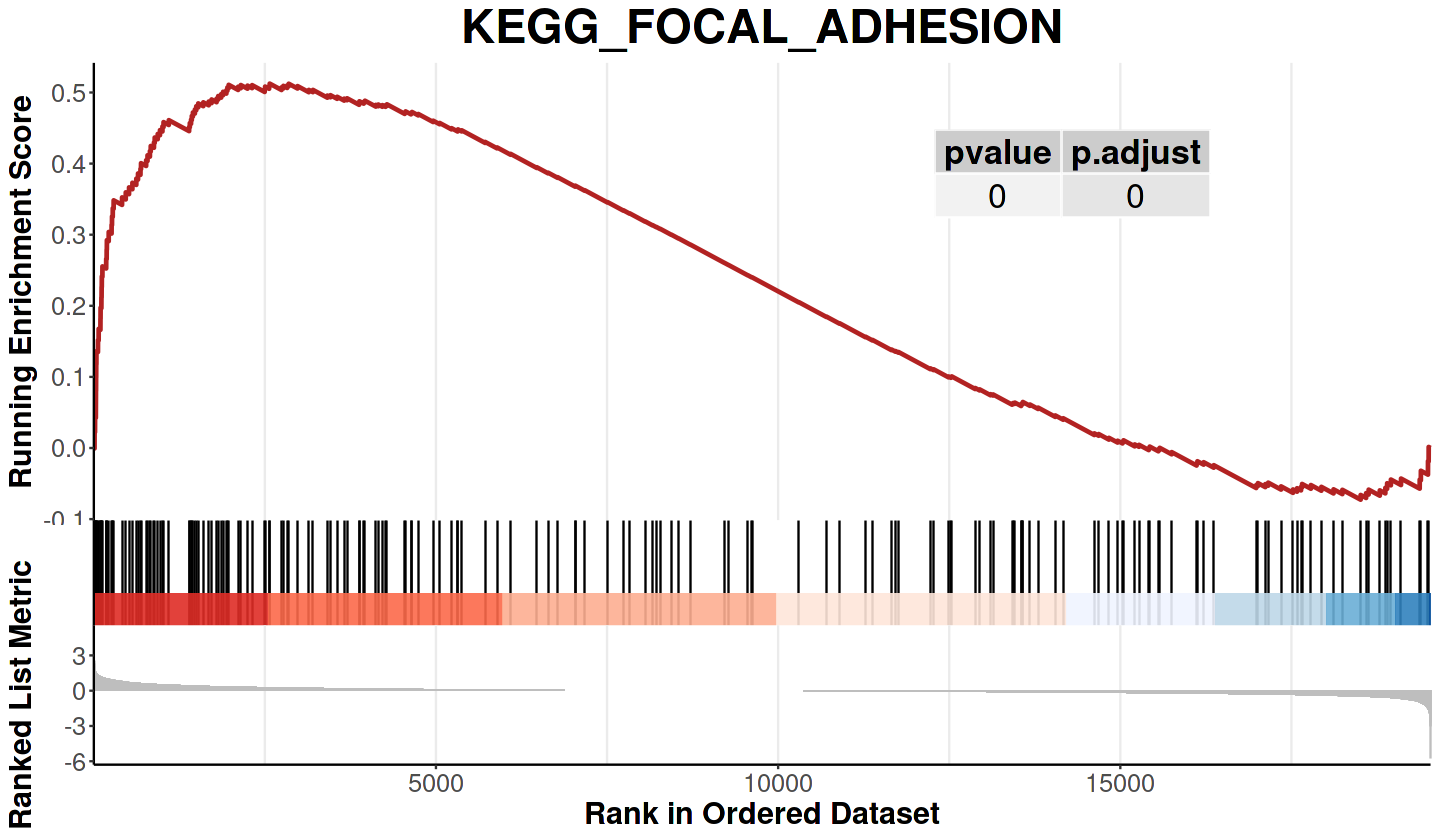

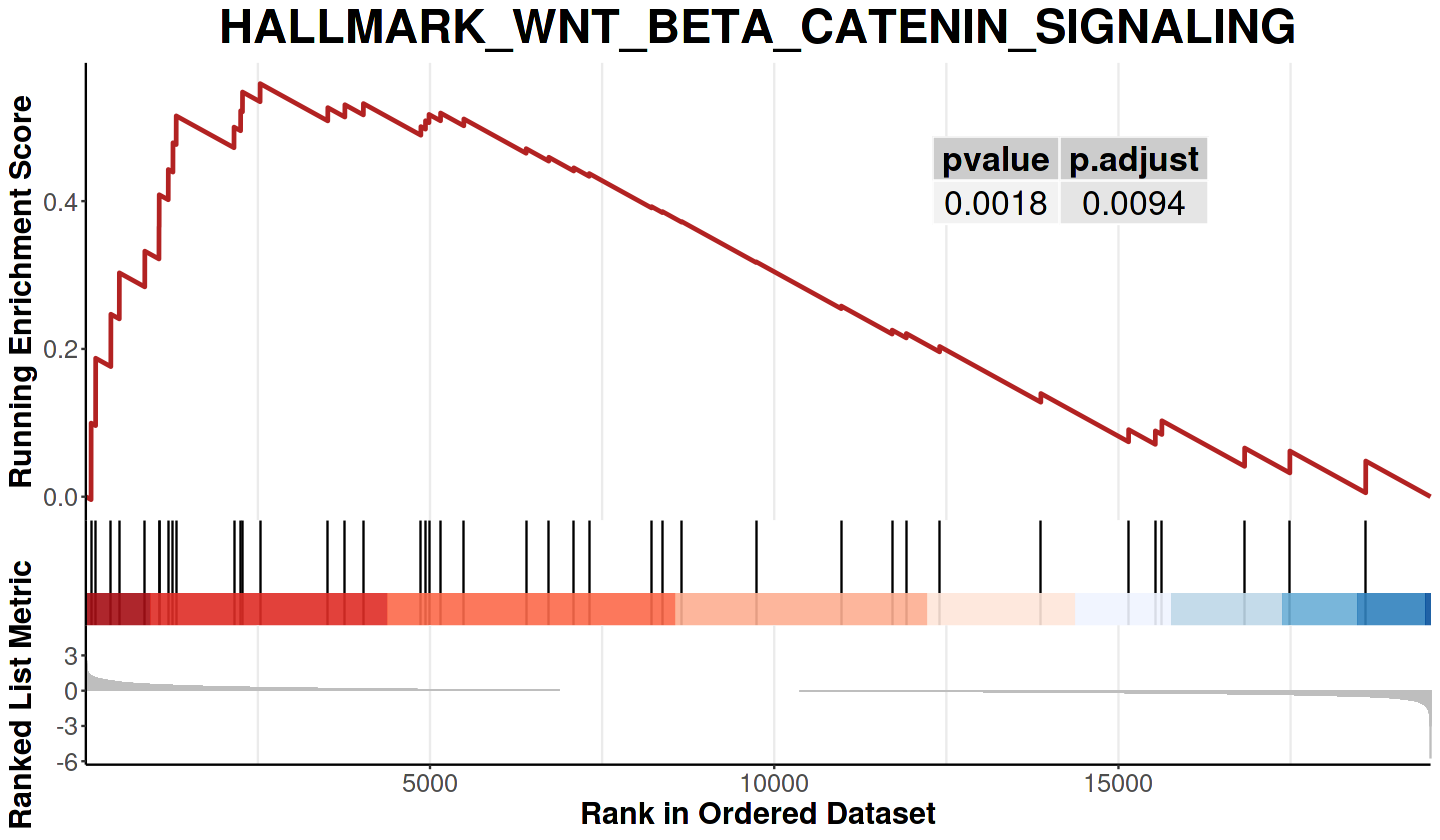

In [87]:
options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"KEGG_ECM_RECEPTOR_INTERACTION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "KEGG_ECM_RECEPTOR_INTERACTION")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"HALLMARK_ANGIOGENESIS",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_ANGIOGENESIS")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"HALLMARK_HYPOXIA",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_HYPOXIA")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"HALLMARK_TGF_BETA_SIGNALING",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_TGF_BETA_SIGNALING")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"KEGG_FOCAL_ADHESION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "KEGG_FOCAL_ADHESION")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset8,"HALLMARK_WNT_BETA_CATENIN_SIGNALING",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_WNT_BETA_CATENIN_SIGNALING")



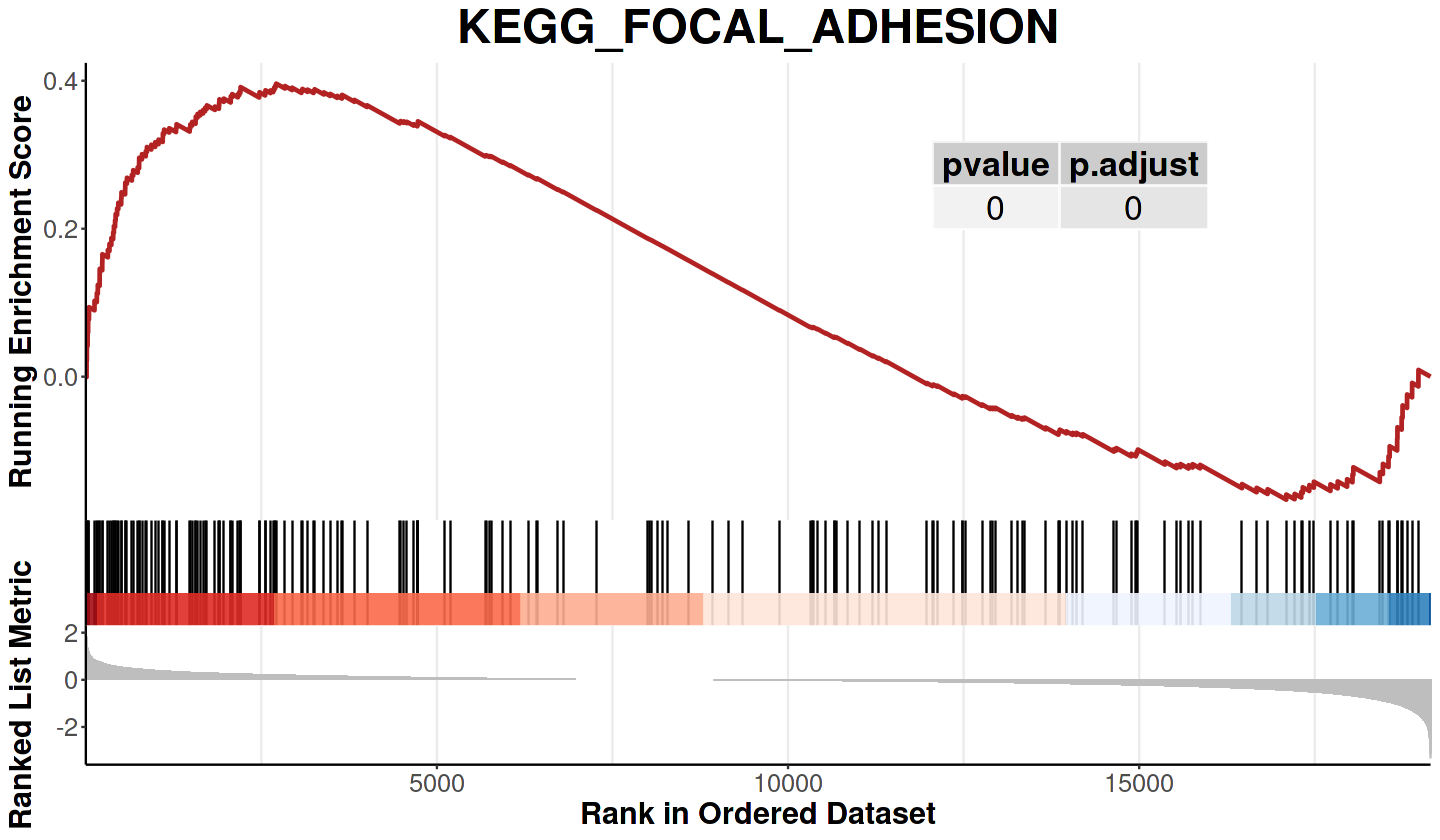

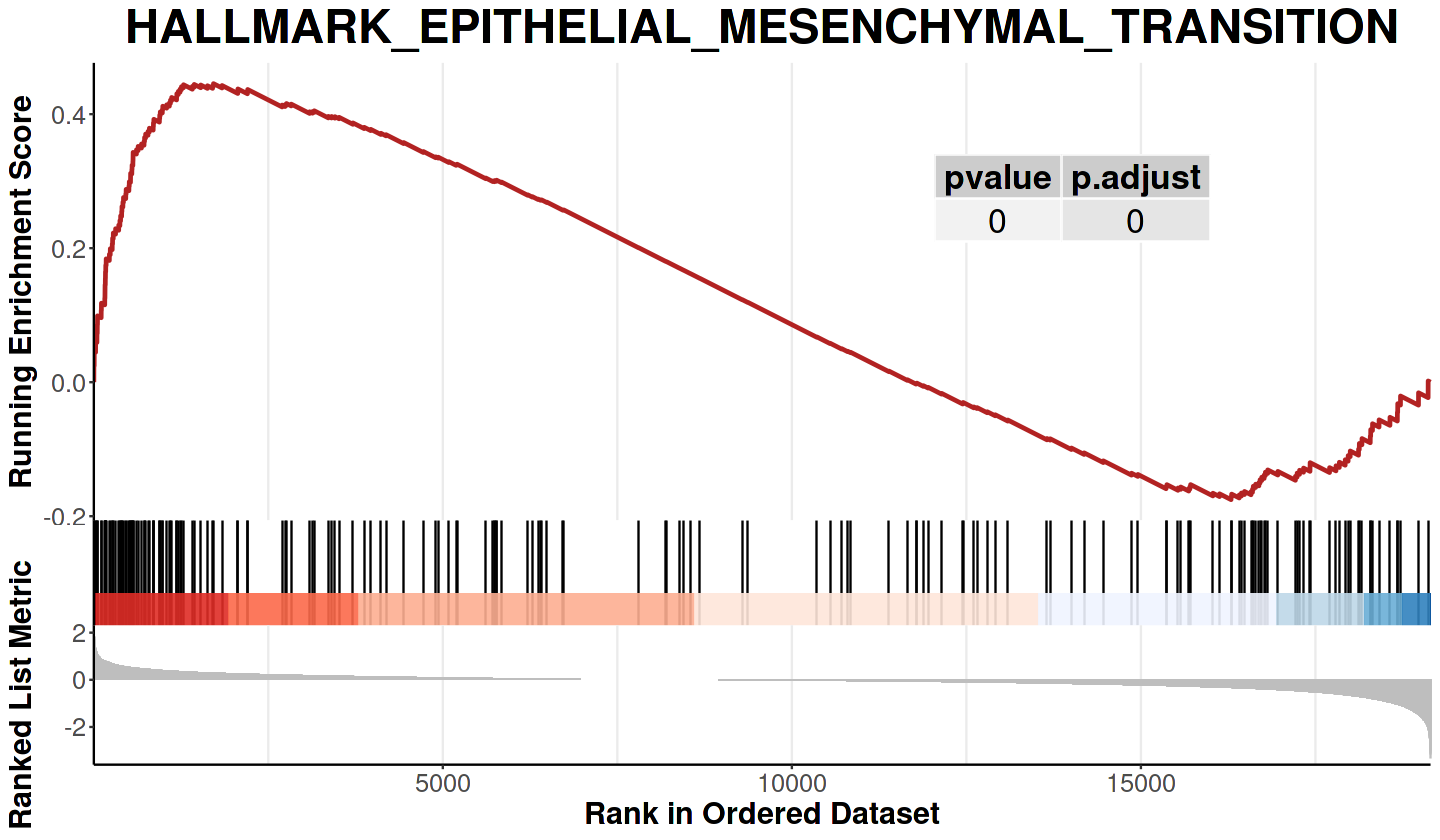

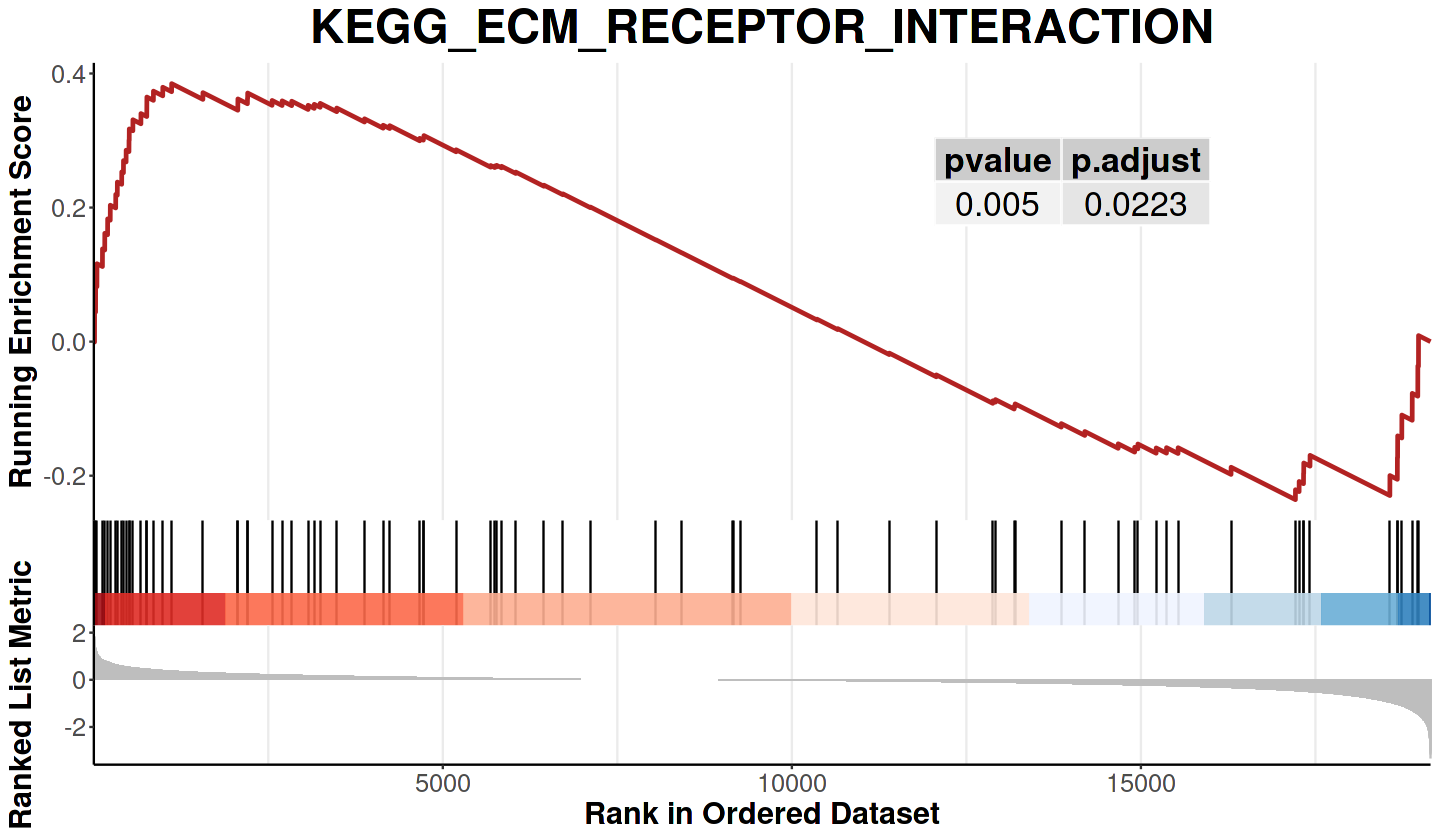

In [90]:
options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset10,"KEGG_FOCAL_ADHESION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "KEGG_FOCAL_ADHESION")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset10,"HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION")


options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset10,"KEGG_ECM_RECEPTOR_INTERACTION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "KEGG_ECM_RECEPTOR_INTERACTION")

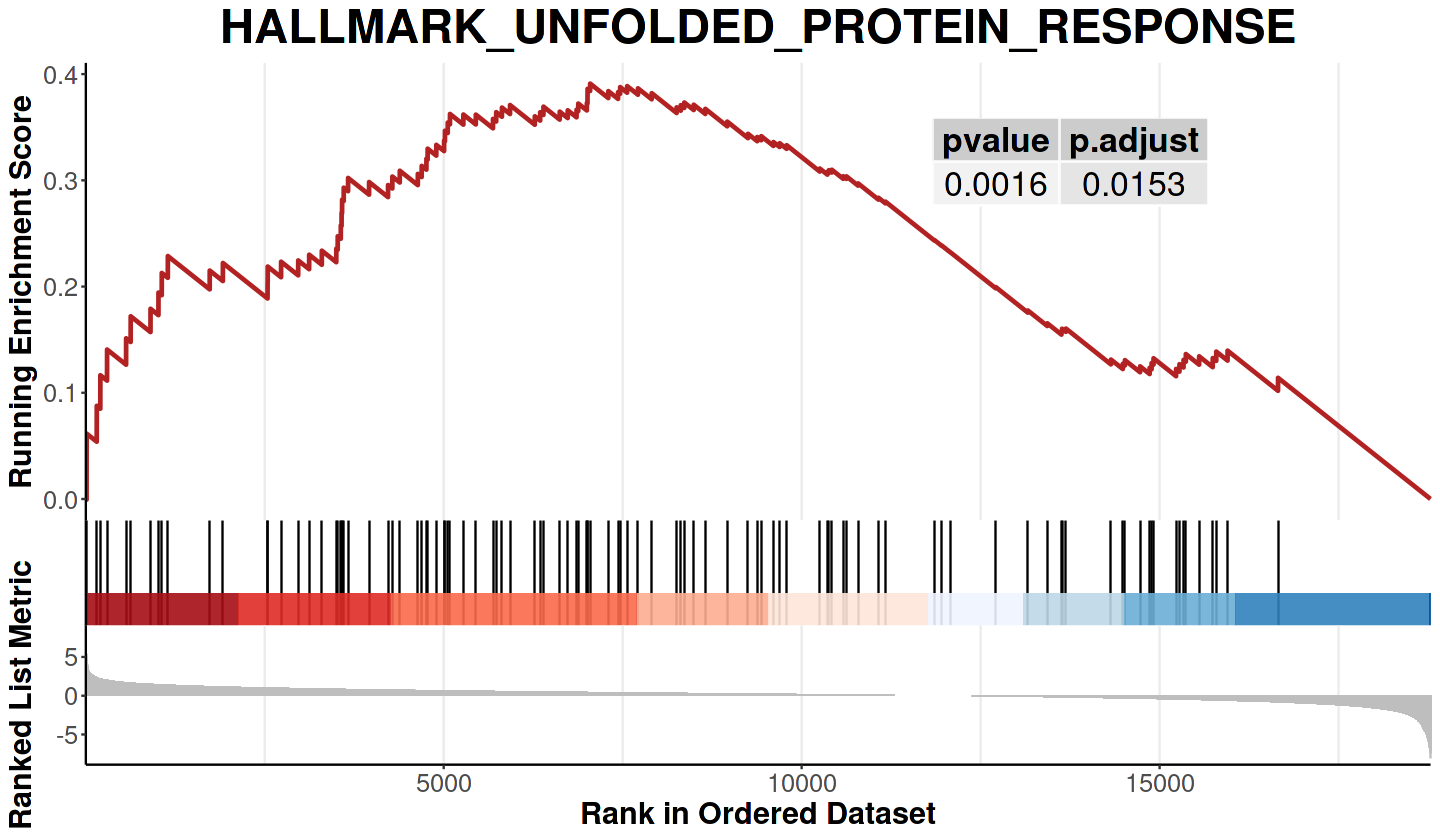

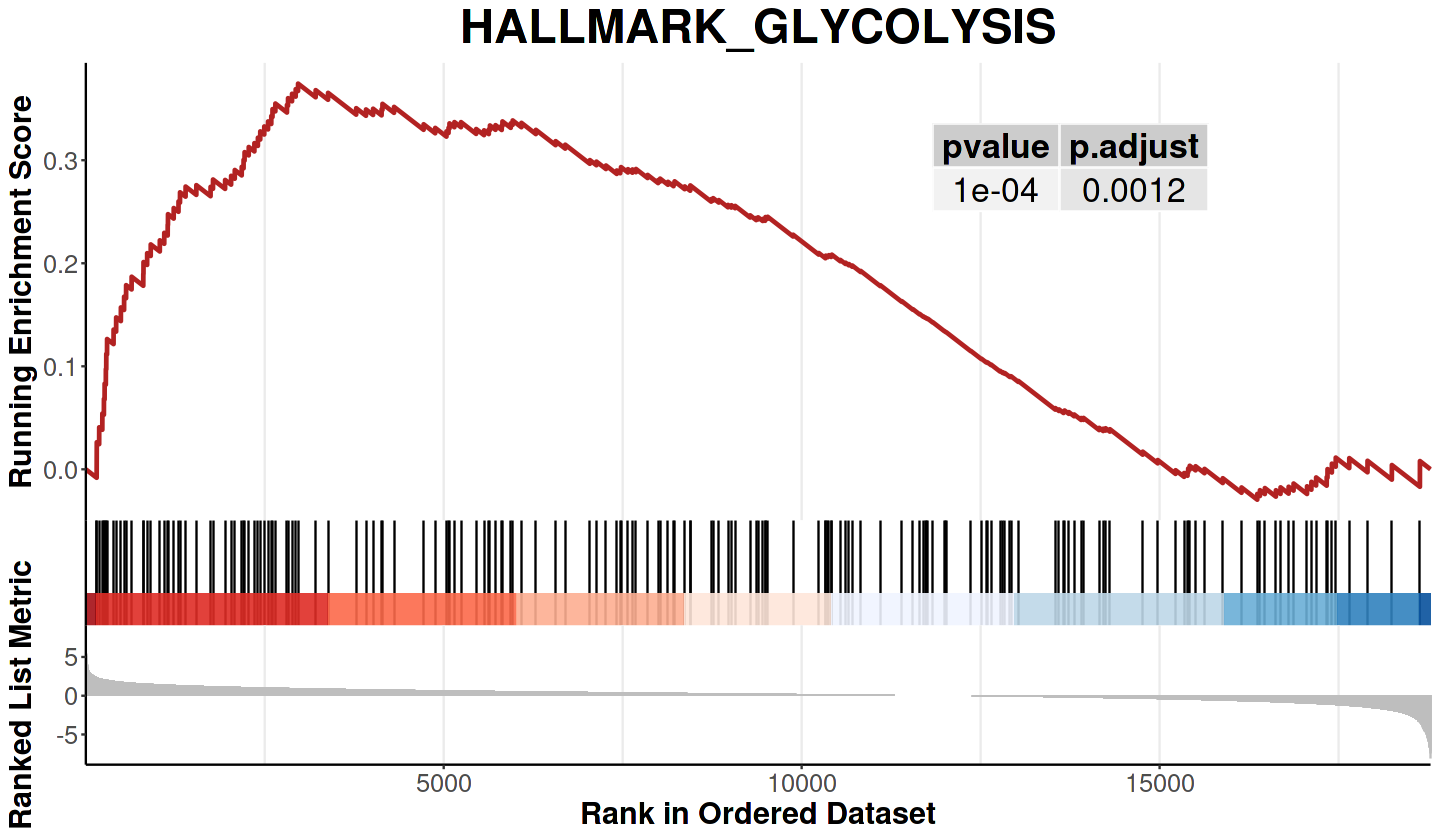

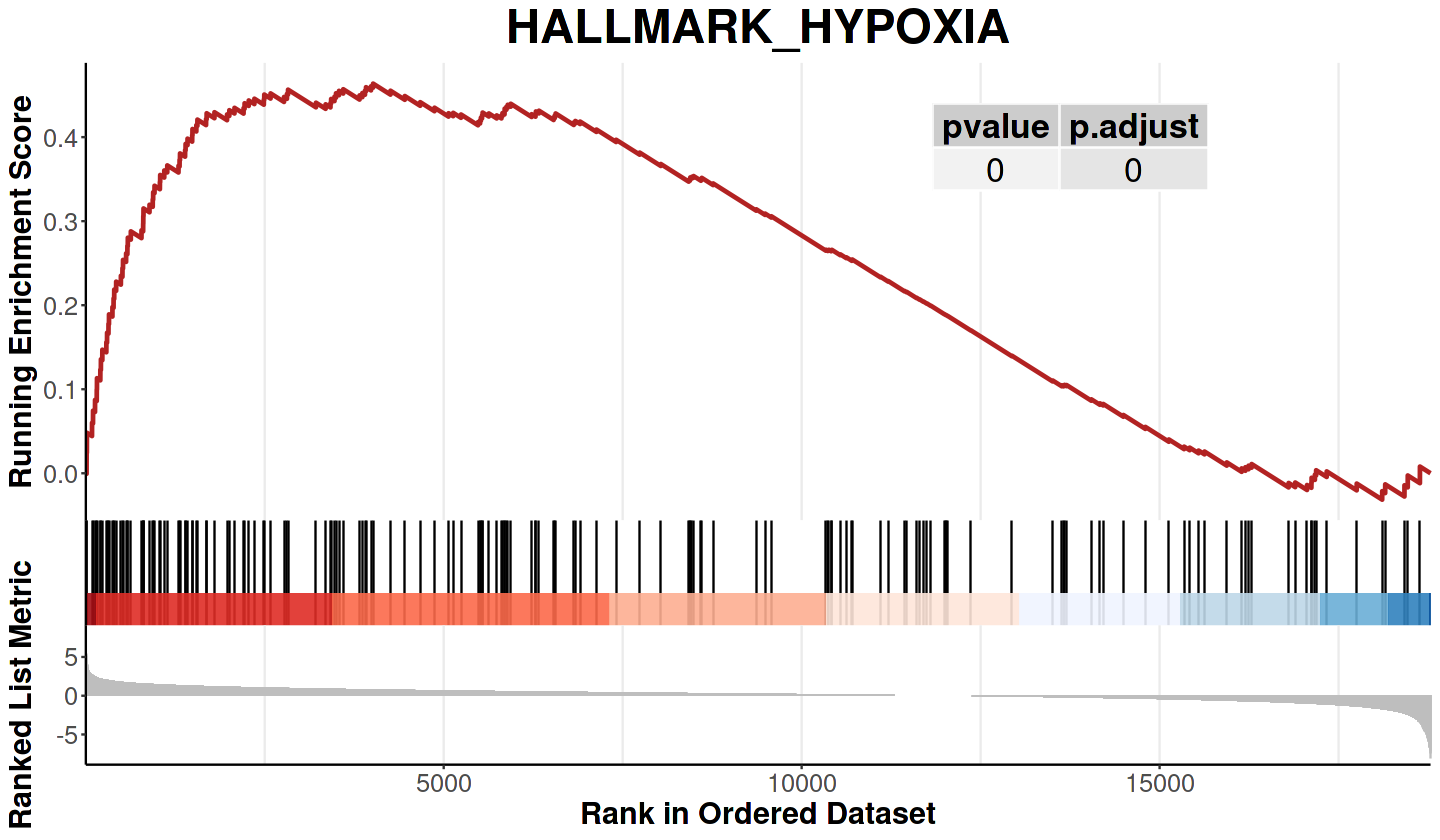

In [93]:
options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset14,"HALLMARK_UNFOLDED_PROTEIN_RESPONSE",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_UNFOLDED_PROTEIN_RESPONSE")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset14,"HALLMARK_GLYCOLYSIS",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_GLYCOLYSIS")

options(repr.plot.height = 7, repr.plot.width = 12)
my_gseaplot2(gl$dataset14,"HALLMARK_HYPOXIA",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "HALLMARK_HYPOXIA")

dataset2:  The number of Patients:  25

dataset2:  The number of Patients:  13 vs 12

Using CM as id variables

dataset8:  The number of Patients:  23

dataset8:  The number of Patients:  11 vs 12

Using CM as id variables

dataset10:  The number of Patients:  16

dataset10:  The number of Patients:  9 vs 7

Using CM as id variables



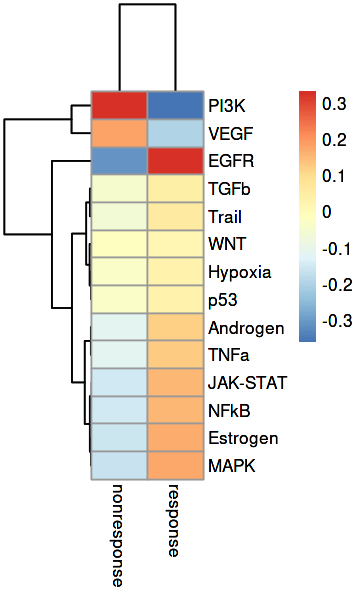

dataset12:  The number of Patients:  51

dataset12:  The number of Patients:  34 vs 17

Using CM as id variables



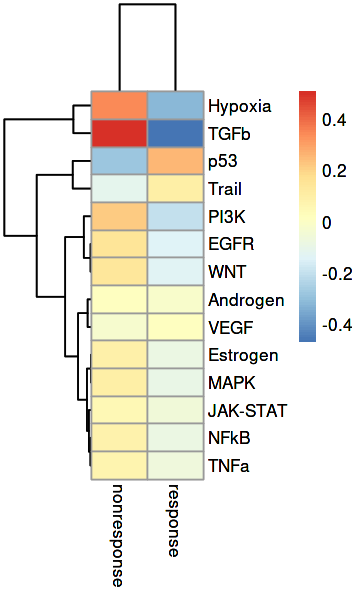

dataset14:  The number of Patients:  5

dataset14:  The number of Patients:  4 vs 1

Using CM as id variables



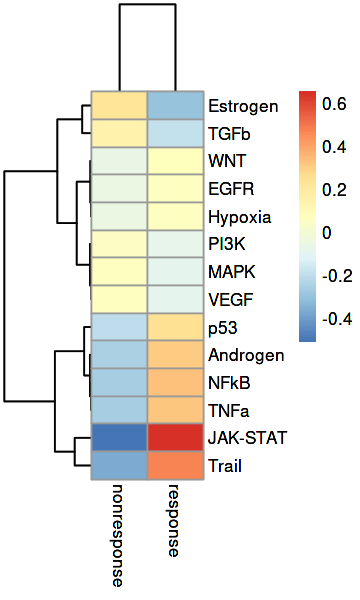

dataset20:  The number of Patients:  26

dataset20:  The number of Patients:  18 vs 7

Using CM as id variables



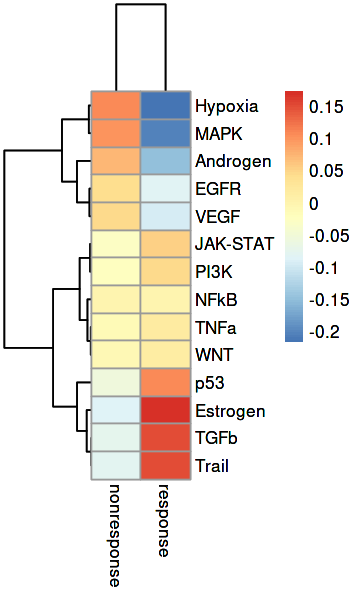

dataset21:  The number of Patients:  80

dataset21:  The number of Patients:  47 vs 33

Using CM as id variables



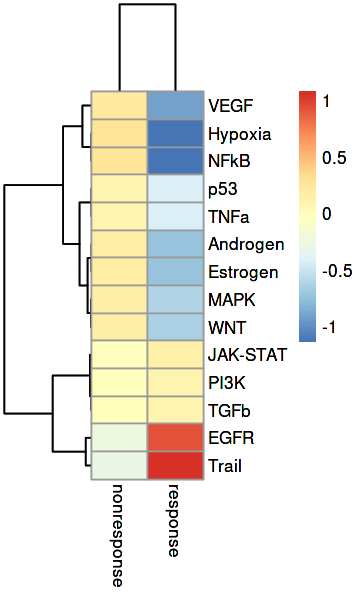

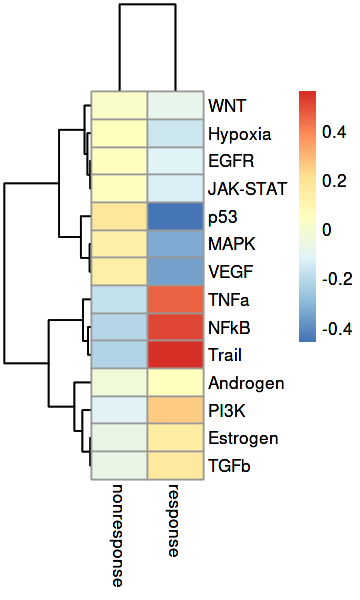

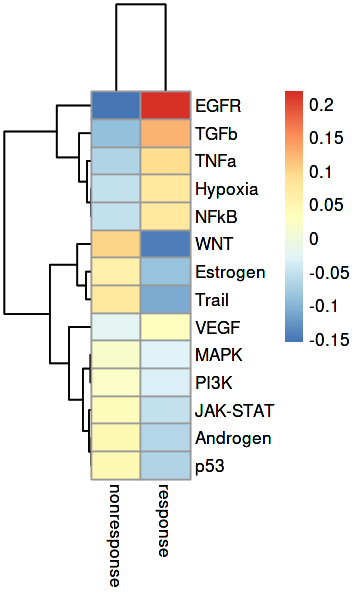

In [51]:
library(progeny)
library(ggpubr)
for(i in intersect(unique(CB_total$dataset),names(RNA_data))){
    
    tmp_cm = CB_total[ CB_total$dataset == i & CB_total$groups == "Mutation", ]
    tmp_rna = RNA_data[[i]]$RNA

    share_p = intersect(rownames(tmp_cm),colnames(tmp_rna))
    message(i,":  The number of Patients:  ",length(share_p))
    tmp_cm = tmp_cm[share_p,]
    tmp_rna = tmp_rna[,share_p]

    nr_p = rownames(tmp_cm)[tmp_cm$CB %in% "nonresponse" ]
    r_p = rownames(tmp_cm)[tmp_cm$CB %in% "response" ]
    message(i,":  The number of Patients:  ",length(nr_p)," vs ",length(r_p))
    tmp_rna = tmp_rna[, c(nr_p,r_p)]
    tmp_cm = tmp_cm[c(nr_p,r_p),]

    m = apply(tmp_rna,1,function(x){sum(x>0)>round(min(length(nr_p),length(r_p))*0.8)})
    tmp_data = tmp_rna[m,]

    pathways <- progeny(as.matrix(tmp_data), scale=TRUE,
                    organism="Human", #如为小鼠，填 "Mouse"
                    top = 100, perm = 1)

    pathways_names = colnames(pathways)

    pathways = as.data.frame(pathways)
    pathways$CM = tmp_cm$CB
    
    pathways2 = reshape2::melt(pathways)
    

    options(repr.plot.height = 5, repr.plot.width = 3)
    
    print(pheatmap::pheatmap(cbind(nonresponse=colMeans(pathways[ pathways$CM == "nonresponse", 1:14]),
                             response=colMeans(pathways[ pathways$CM == "response", 1:14])),
                       show_colnames = T))
    
#     options(repr.plot.height = 5, repr.plot.width = 3)
#     print(ggplot(pathways2,aes(y = value,x = CM,color=CM))+geom_boxplot()+facet_wrap("~variable")+stat_compare_means()+theme_bw())
}

##### CPTAC analysis

In [96]:
CPTAC_data = readRDS("/srv/shiny-server/SNVIO_ALIYUN/data/CPTAC/CPTAC.rds")

In [97]:
library(ggrepel)

new_genelist = list(
    
    "Components"= c("C2","C3","C4A","C5","C6","C7","C8A","C8B","C8G","C9"),
    "Pattern_recognition" = c("C1QA","MBL2","FCN1","FCN2","FCN3","CFP","CRP","CFHR1","CFHR2","CFHR3","CFHR4","CFHR5"),
    "Proteases" = c("C1R","C1RL","C1S","MASP1","MASP2","CFI","CFB","CFD"),
    "Receptors" = c("CR1","CR2","C3AR1","C5AR1","C5AR2","C1QBP","ITGAM","ITGAX","VSIG4","CD93"),
    "Regulators" = c("C4BPA","C4BPB","CPN1","CPN2","CALR","CLU","CFH","CD46","CD55","CD59","VTN","SERPING1")

)

new_complement = vector()
for( i in names(new_genelist) ){
    new_complement = rbind(data.frame(gs_name=rep(i,length(new_genelist[[i]])),entrez_gene=NA,gene_symbol=new_genelist[[i]]),new_complement)
}

KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

Complement = rbind(REACTOME[ grepl("COMPLEMENT",REACTOME$gs_name) ,],
                   HALLMARK[ grepl("COMPLEMENT",HALLMARK$gs_name) ,],
                   GO_BP[ grepl("COMPLEMENT",GO_BP$gs_name) ,],
                   KEGG[ grepl("COMPLEMENT",KEGG$gs_name) ,],
                   new_complement
                  )

Complement = Complement[!duplicated(Complement),]

complement_genes = unique(c( unique(REACTOME[ grepl("COMPLEMENT",REACTOME$gs_name) ,"gene_symbol",drop=TRUE]),
                             unique(HALLMARK[ grepl("COMPLEMENT",HALLMARK$gs_name) ,"gene_symbol",drop=TRUE]),
                             unique(GO_BP[ grepl("COMPLEMENT",GO_BP$gs_name) ,"gene_symbol",drop=TRUE]),
                             unique(KEGG[ grepl("COMPLEMENT",KEGG$gs_name) ,"gene_symbol",drop=TRUE]),
                             unique(unlist(new_genelist))
                            )
                          )

new_genelist = c(new_genelist,pathway_list[setdiff(unique(Complement$gs_name),names(new_genelist))])

In [98]:
CPTAC_cohort_cal_pm = function(TCGA,cancer_type,gene,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$TCGA[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$TCGA[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$TCGA)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$TCGA)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$TCGA[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

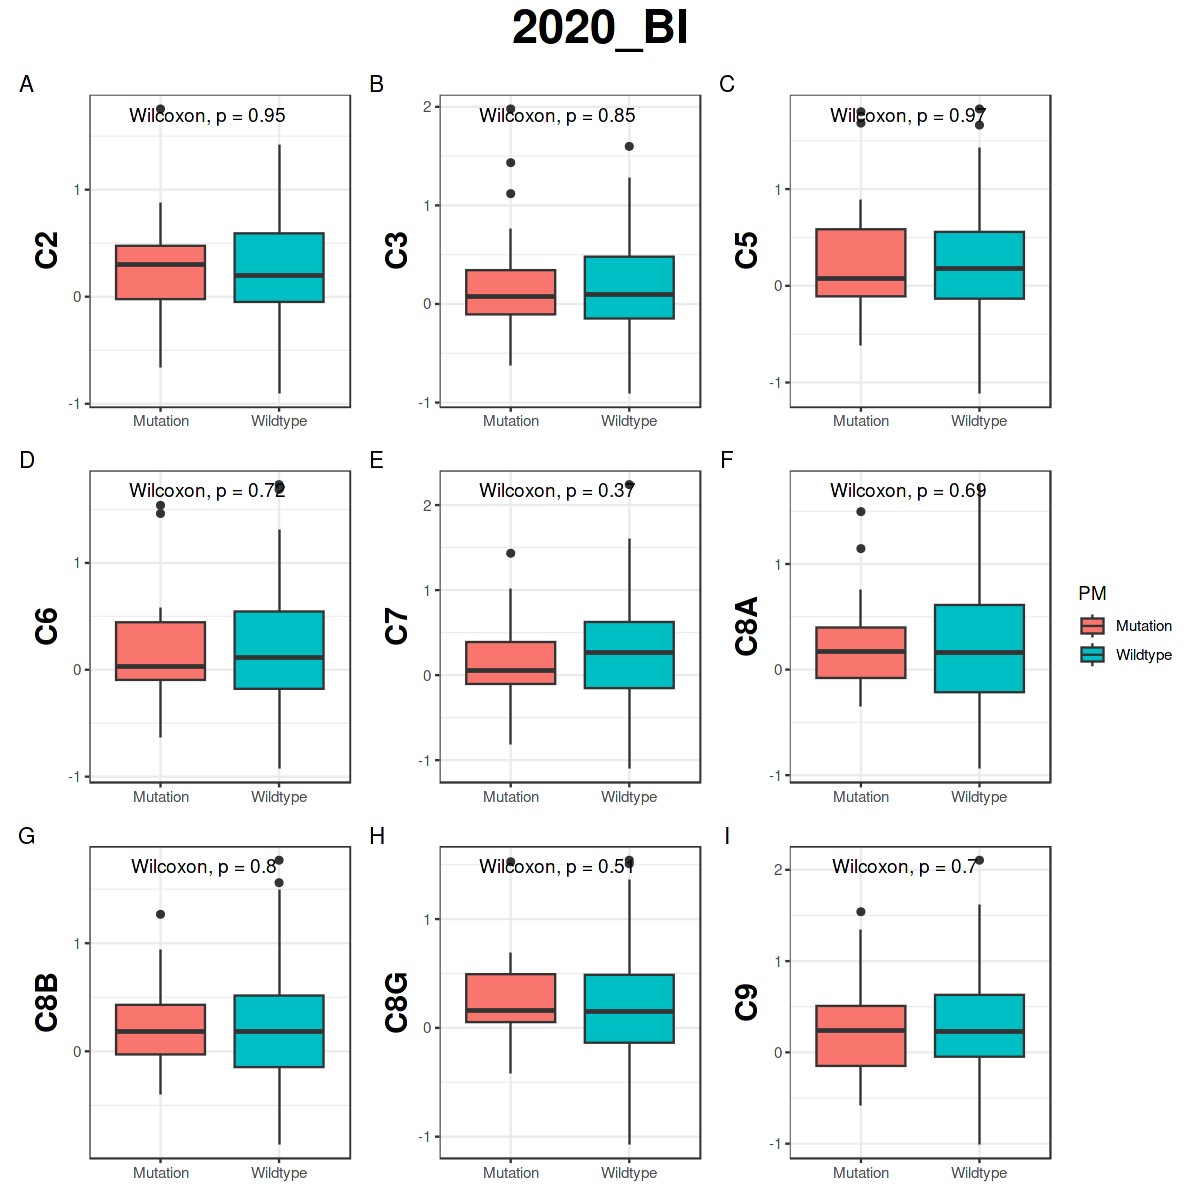

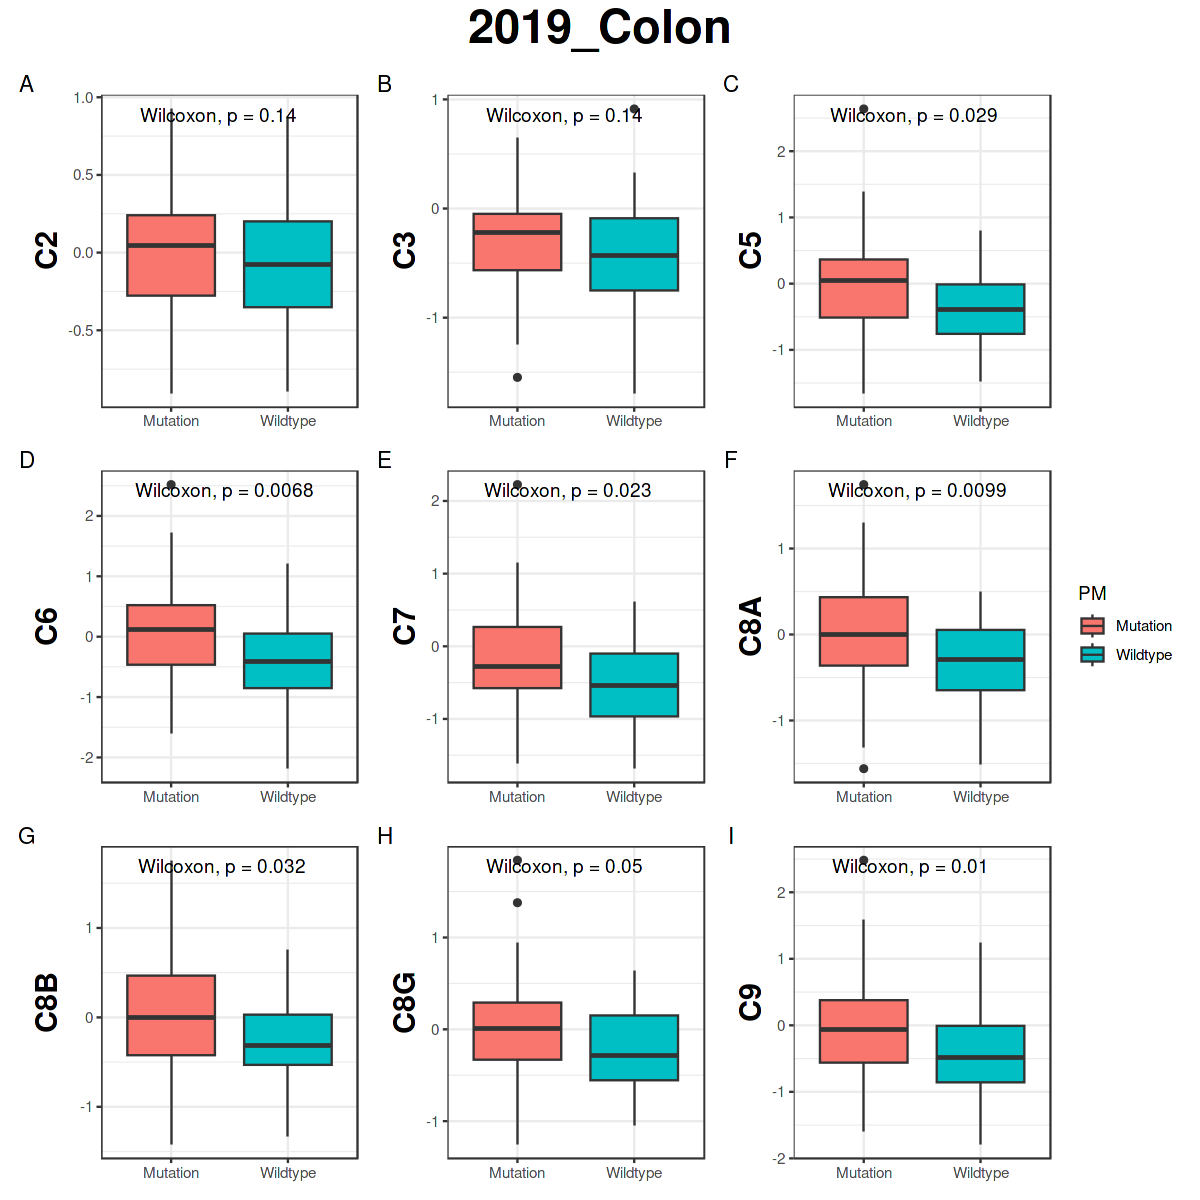

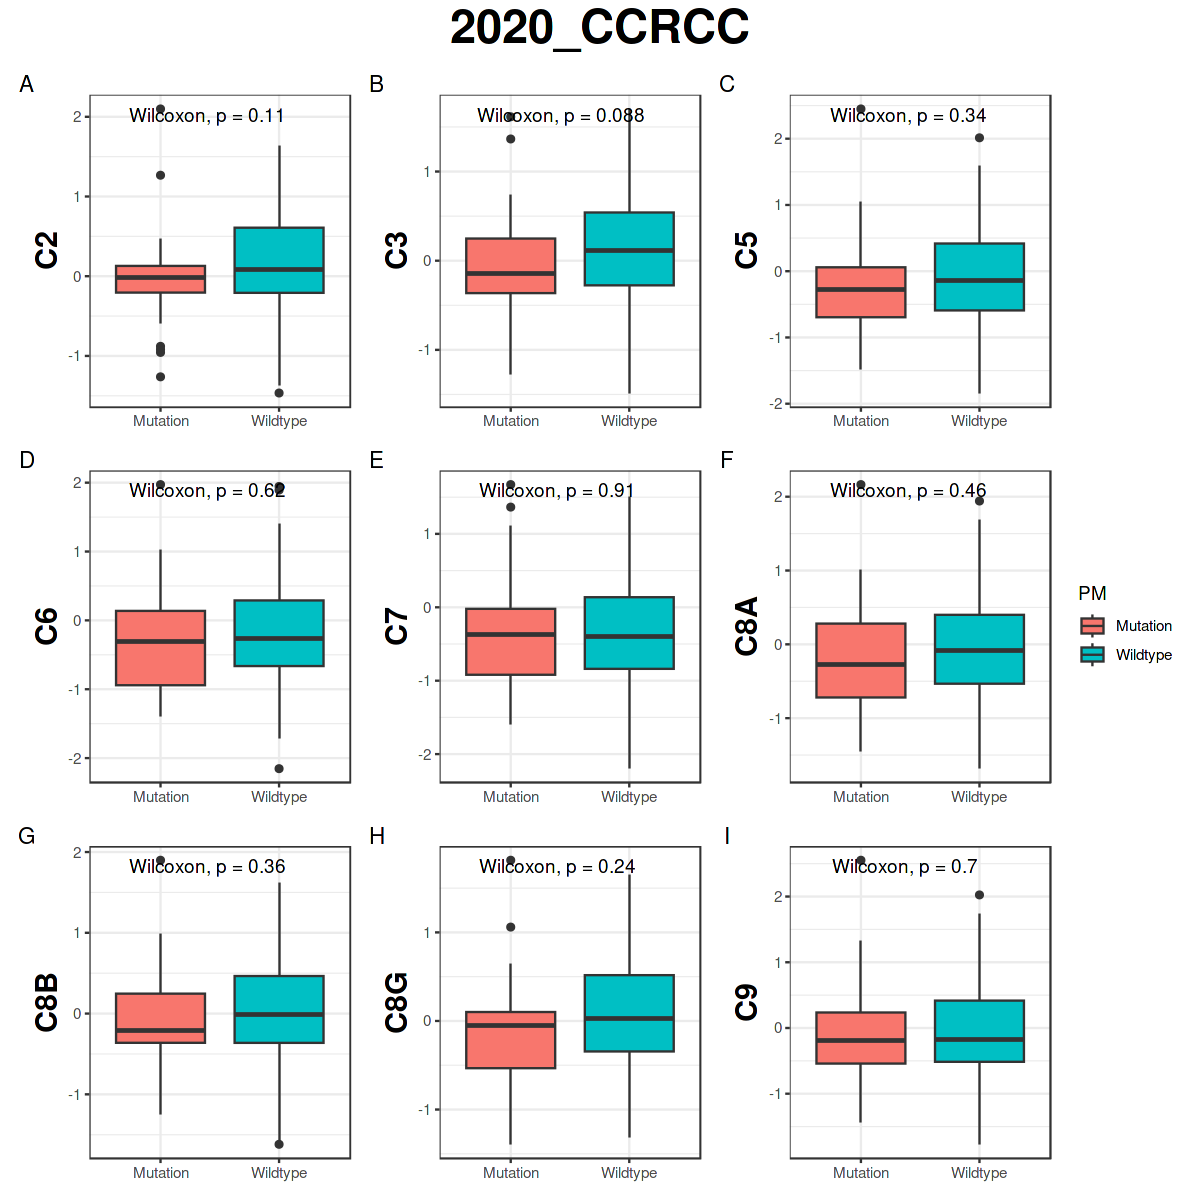

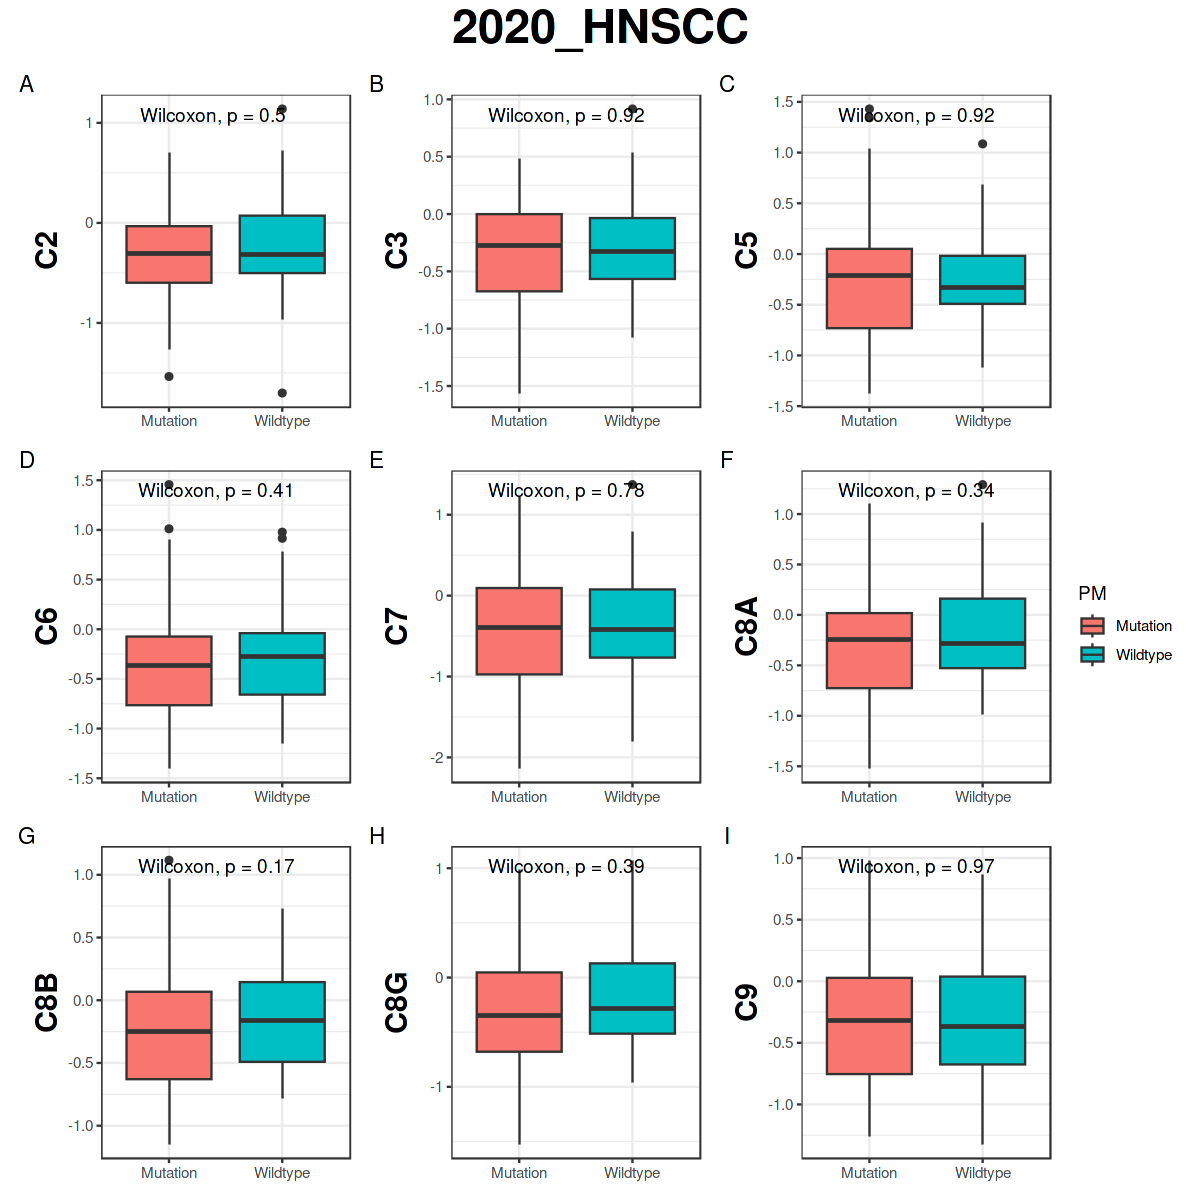

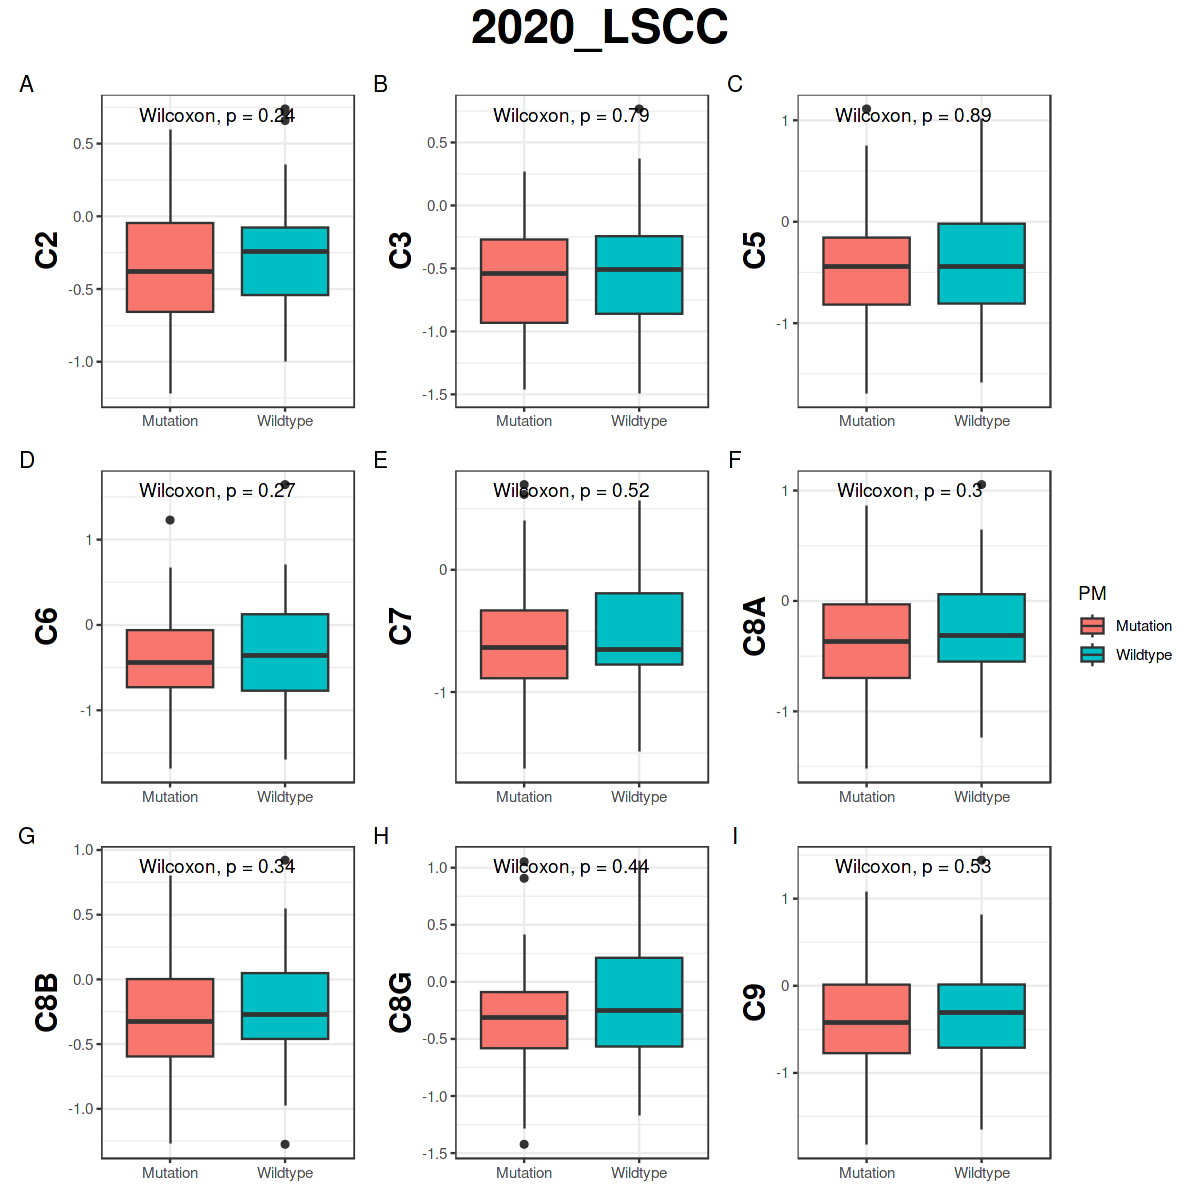

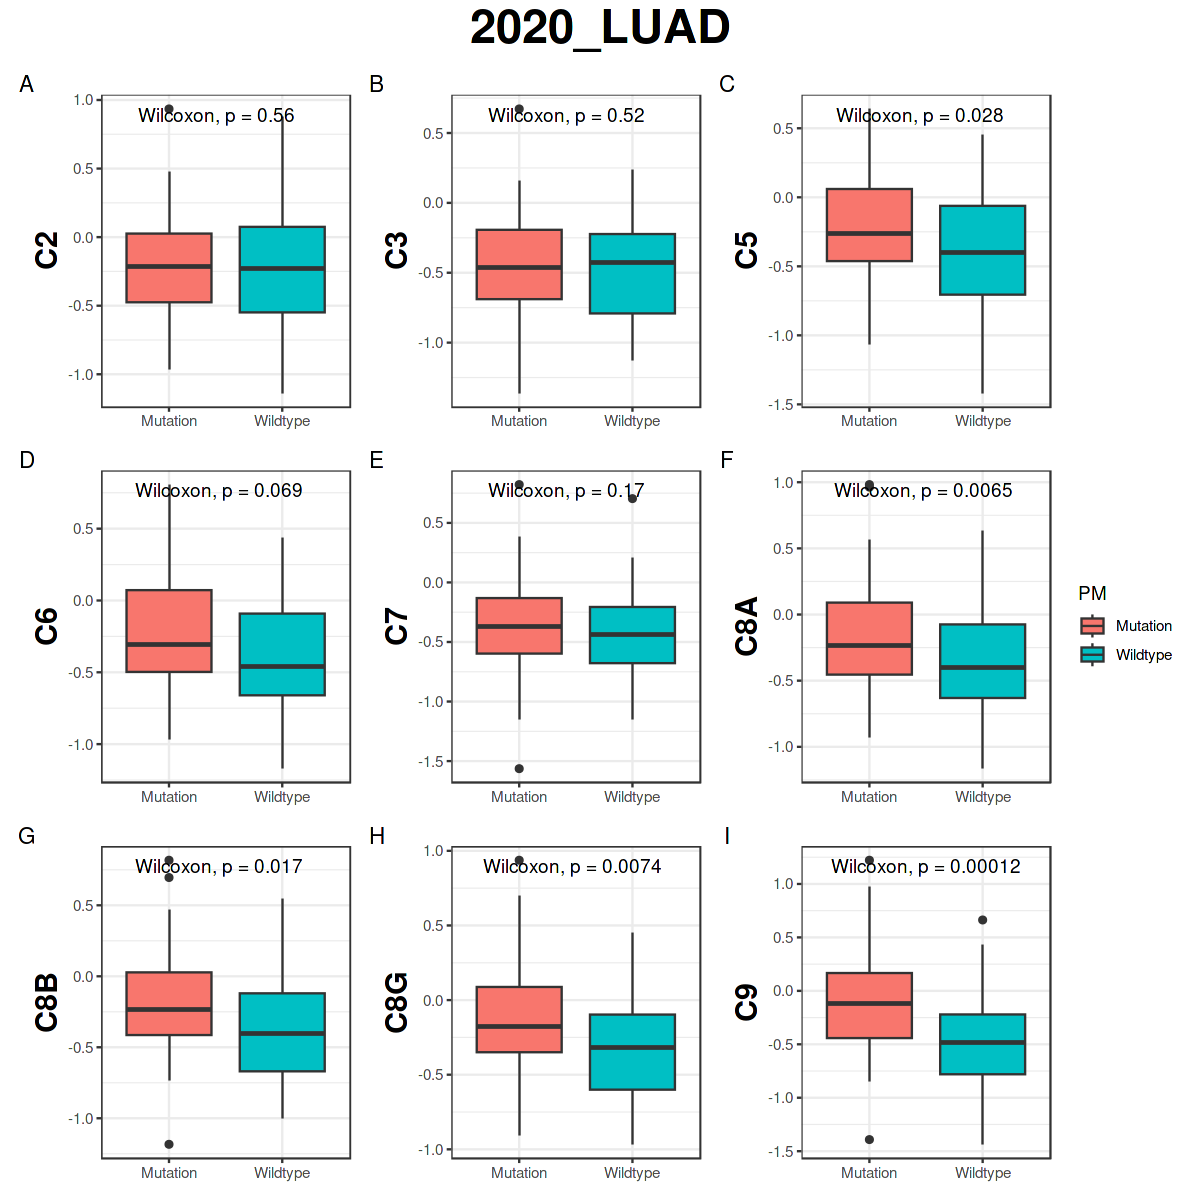

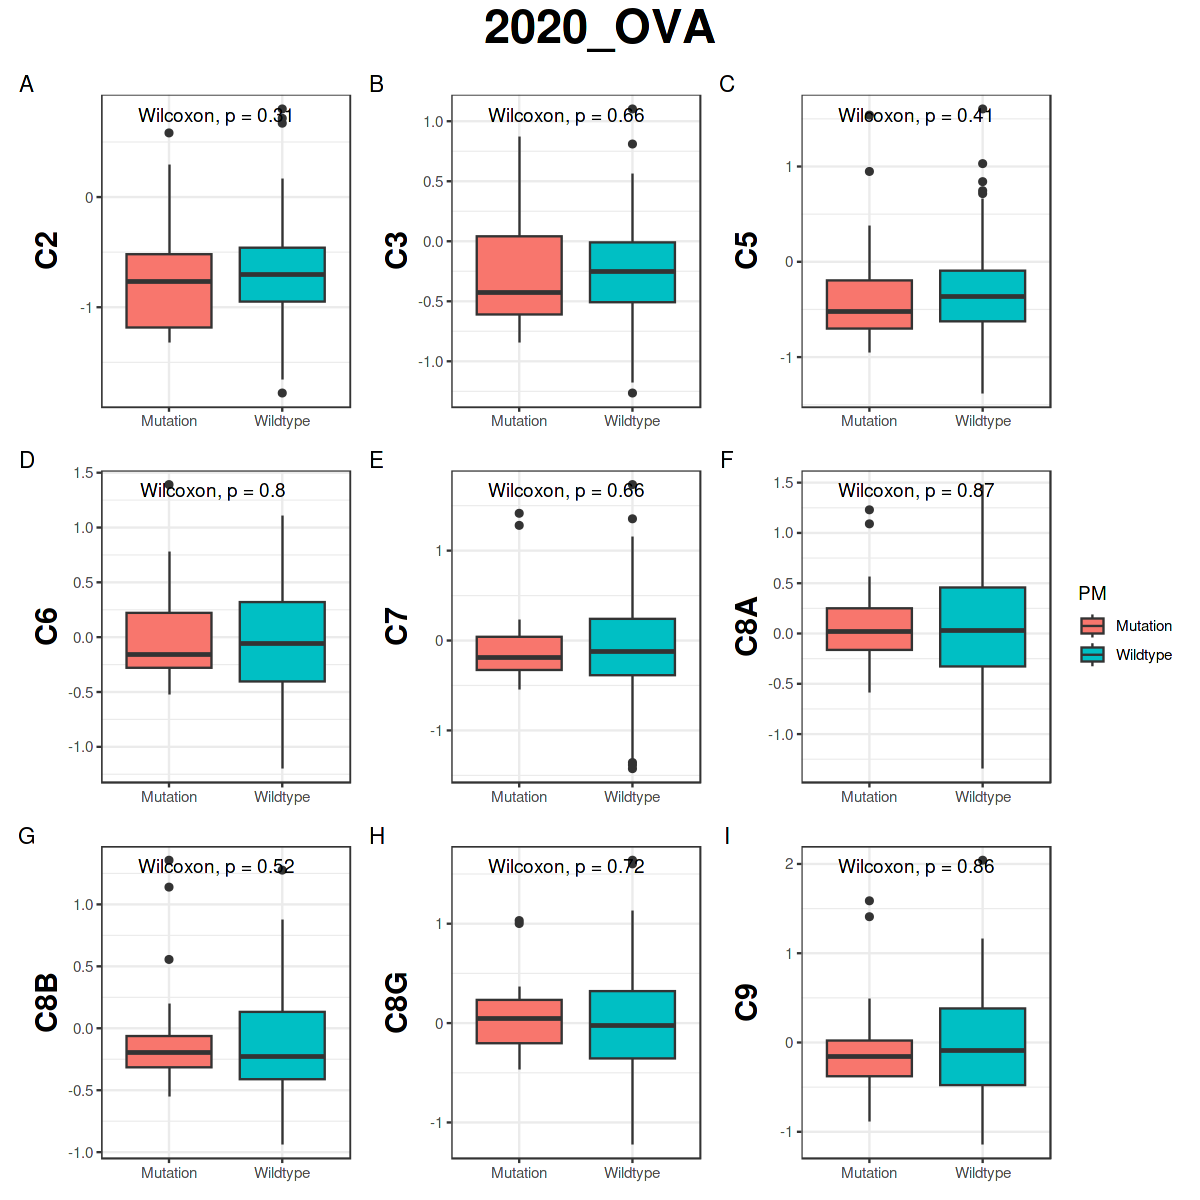

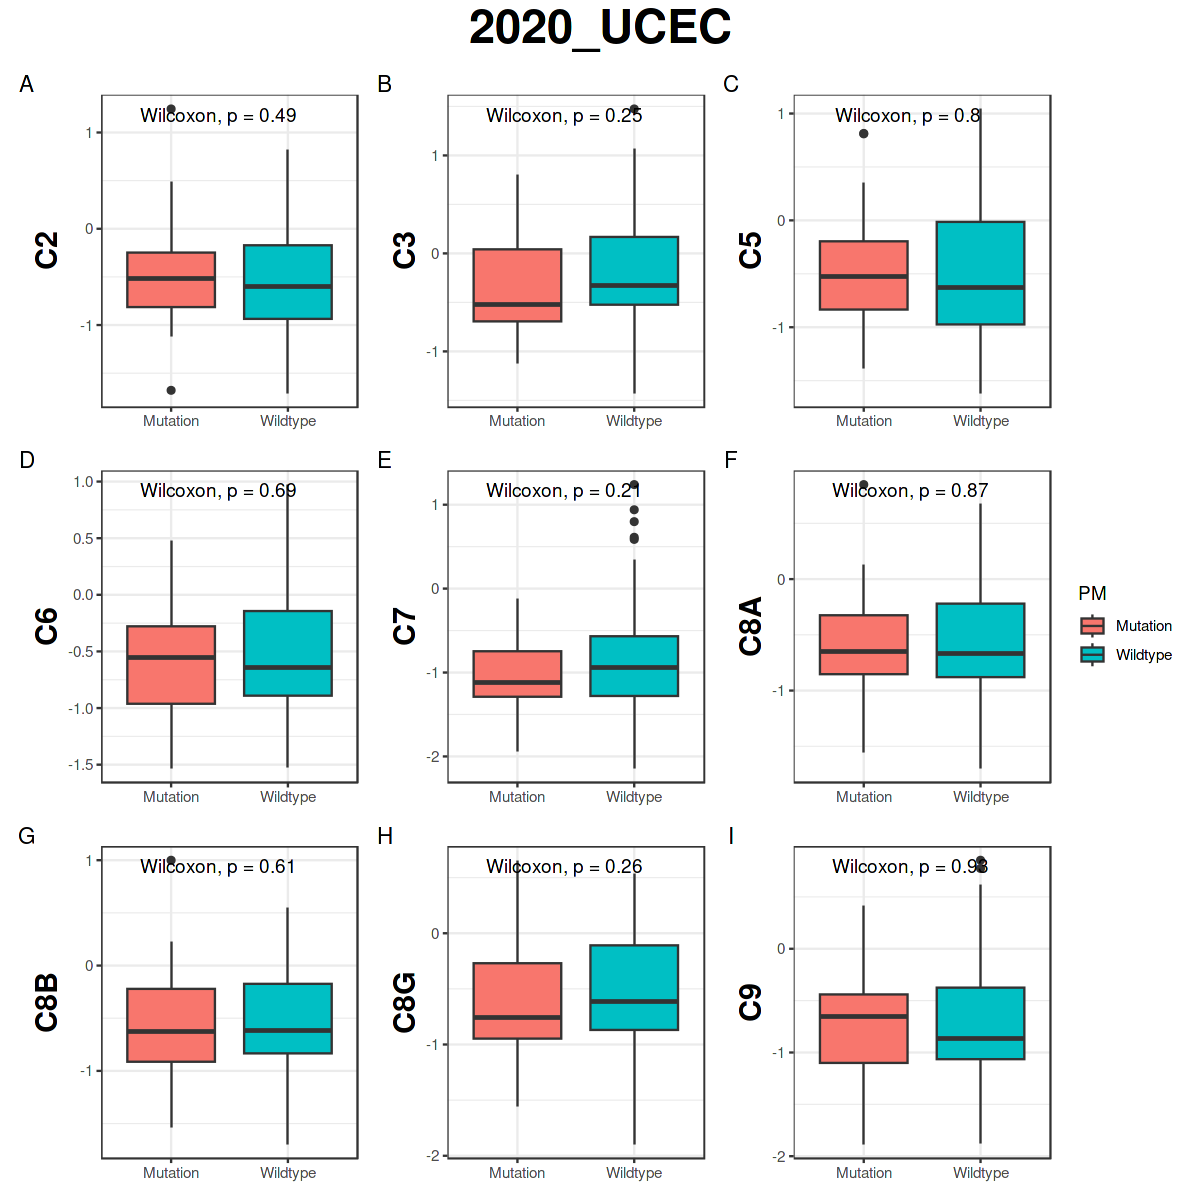

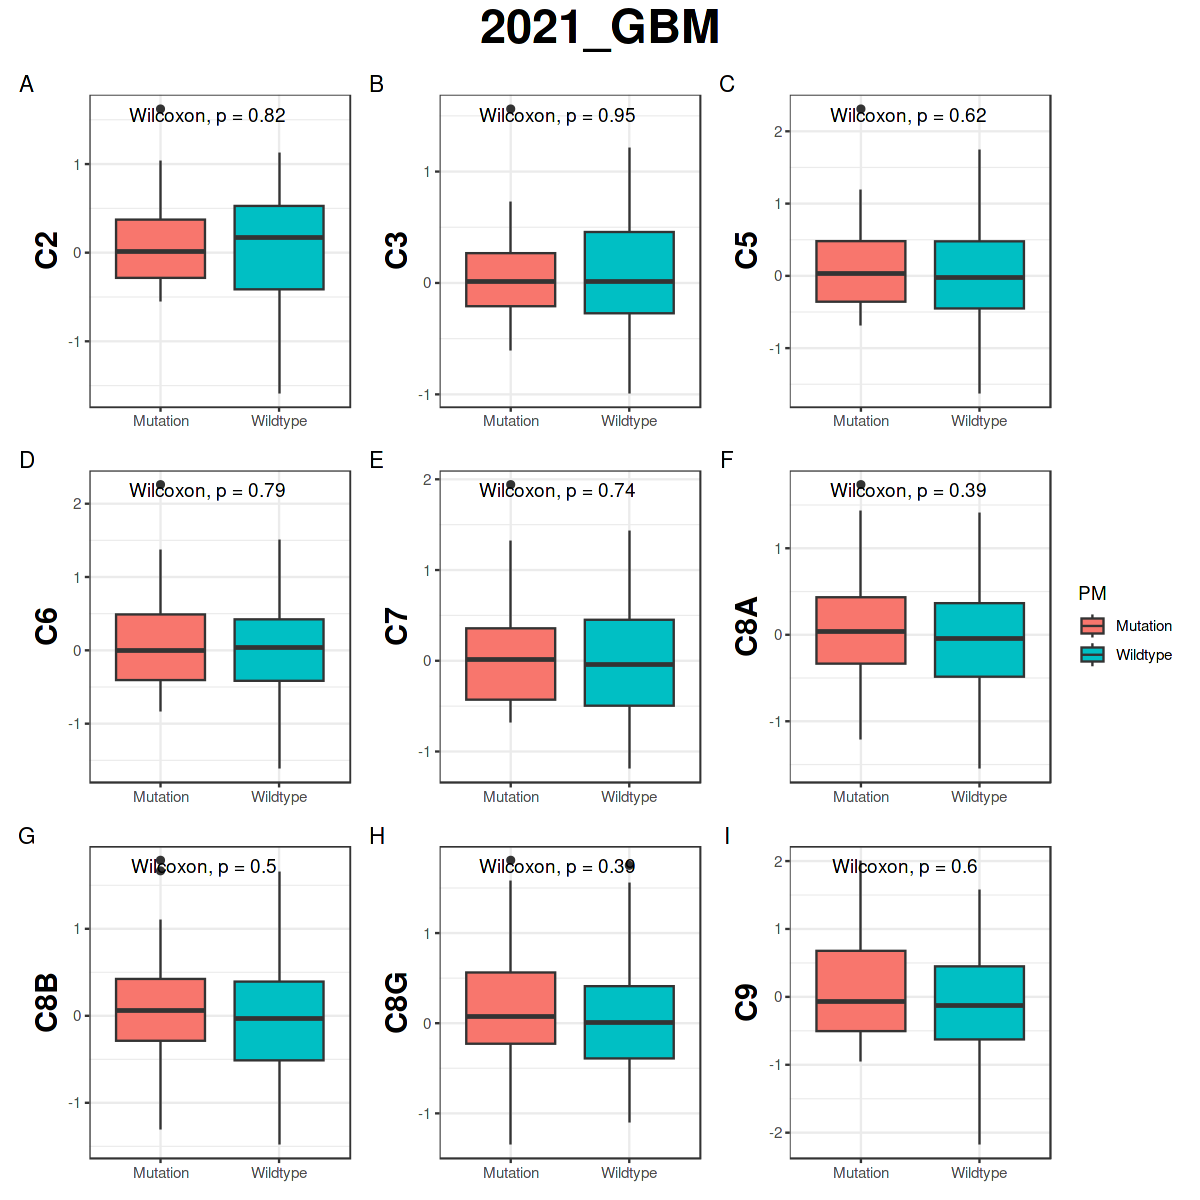

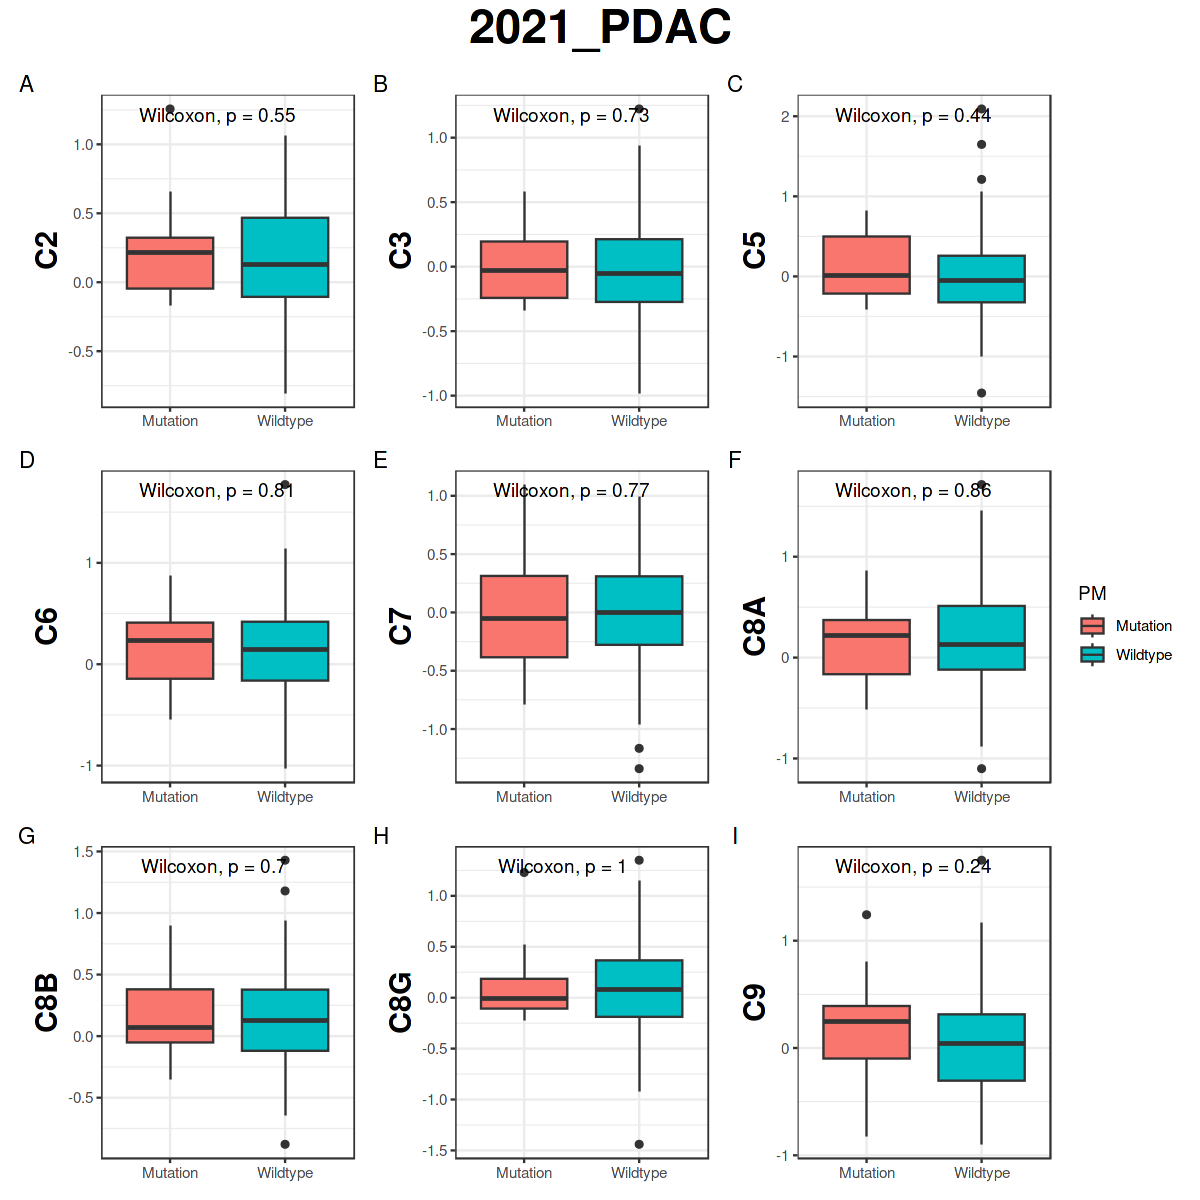

In [139]:
for(i in names(CPTAC_data)){
    tmp_cohort = CPTAC_cohort_cal_pm(CPTAC_data,i,"GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
    tmp_data = CPTAC_data[[i]]$protein

    pID = colnames(tmp_data)
    mID = intersect(tmp_cohort$mut,pID)
    wID = intersect(tmp_cohort$wt,pID)
    tmp_data = tmp_data[,c(mID,wID)]

    tmp_data = as.data.frame(t(tmp_data))
    tmp_data$PM = NA
    tmp_data[mID,"PM"] = "Mutation"
    tmp_data[wID,"PM"] = "Wildtype"

    n = 1
    for(c in new_genelist$Components){
        if( c %in% colnames(tmp_data)){
            tmp_data$gene = tmp_data[[c]]
            if(n == 1){
                p = ggplot(tmp_data,aes(x = PM,y=gene,fill=PM))+
                    geom_boxplot()+
                    ylab(c)+
                    stat_compare_means(vjust = 0.9)+
                    theme_bw()+
                    theme(axis.title.x = element_blank(),axis.title.y = element_text(size = 18,face="bold"))
            }else{
                p = p + ggplot(tmp_data,aes(x = PM,y=gene,fill=PM))+
                            geom_boxplot()+
                            ylab(c)+
                            stat_compare_means(vjust = 0.9)+
                            theme_bw()+
                            theme(axis.title.x = element_blank(),axis.title.y = element_text(size = 18,face="bold"))
            }
            n = n + 1
        }

    }

    options(repr.plot.height = 10, repr.plot.width = 10)
print(    p +  
    plot_layout(guides = 'collect')+
    plot_annotation(title = i,
                    tag_levels = "A",
                    theme = theme(plot.title = element_text(hjust = 0.5,face="bold",size = 28))))
}